In [119]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from util import RuleClassifier, print_complexity, evaluate_counterfactual_fidelity,\
                 constraint_matrix_to_rules, calc_constraint_error
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order, print_rules
from clustering import make_clustering
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
with open('task_with_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [5]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                               explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                                 explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.test.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.test.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [37:09,  2.29s/it]                         
Exact explainer: 978it [44:33,  2.75s/it]                         

CPU times: user 3h 55min 47s, sys: 13min 35s, total: 4h 9min 22s
Wall time: 1h 21min 42s


# Traditional SHAP Explanations

In [13]:
with open('indiv.test.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [14]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

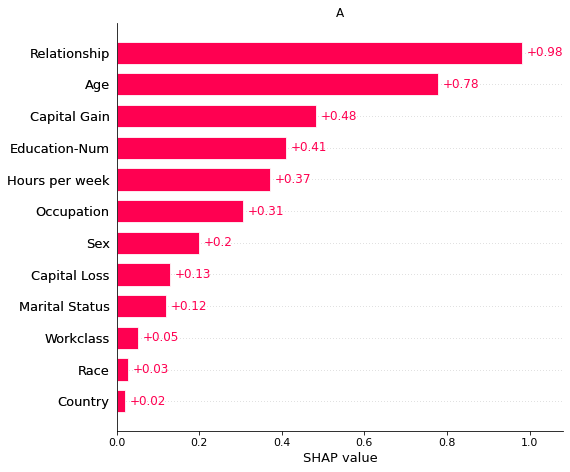

In [15]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

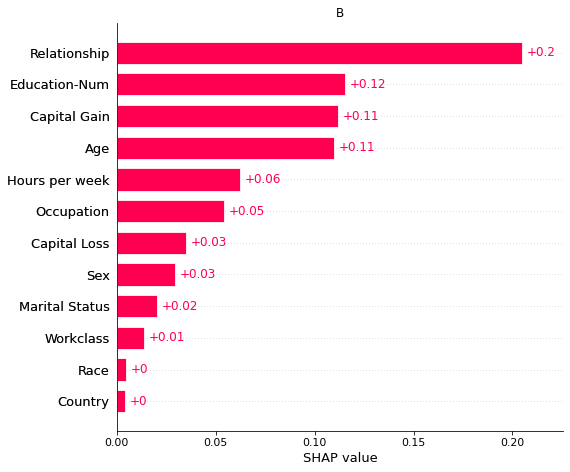

In [16]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [17]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 185 ms, sys: 16.2 ms, total: 201 ms
Wall time: 120 ms


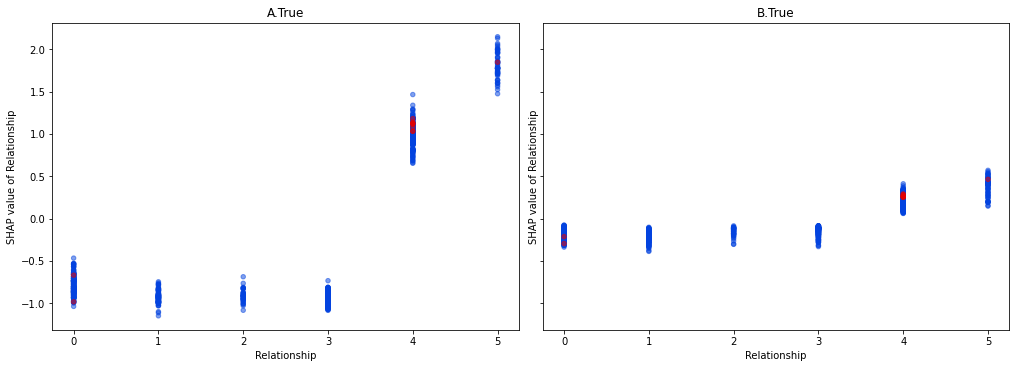

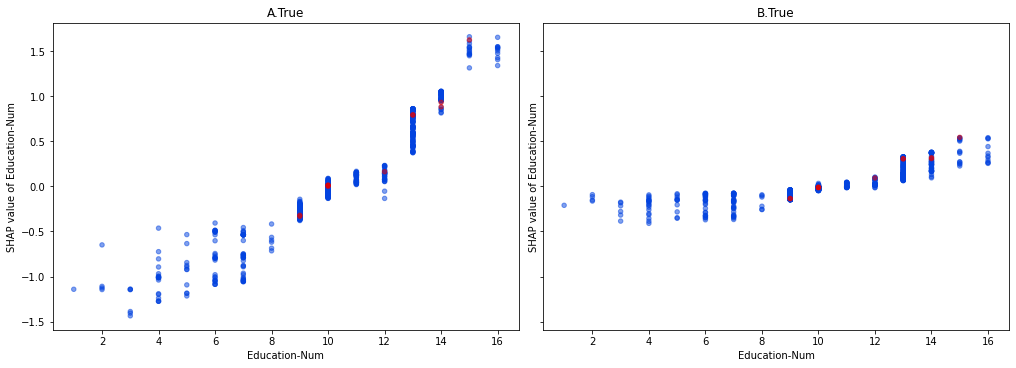

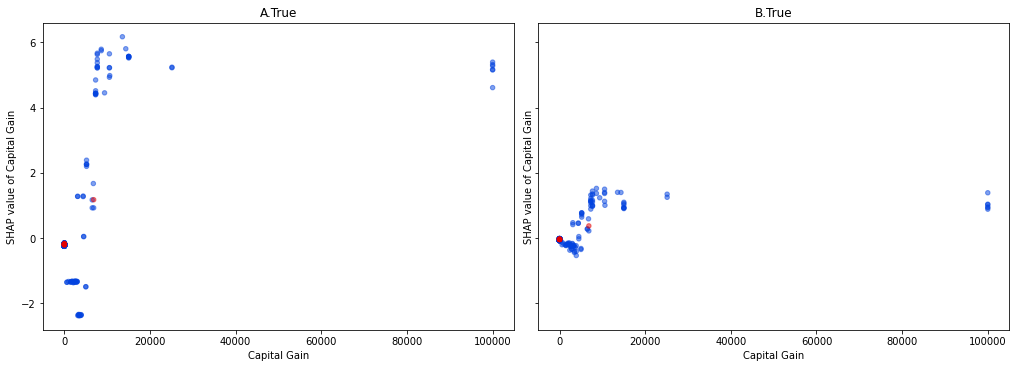

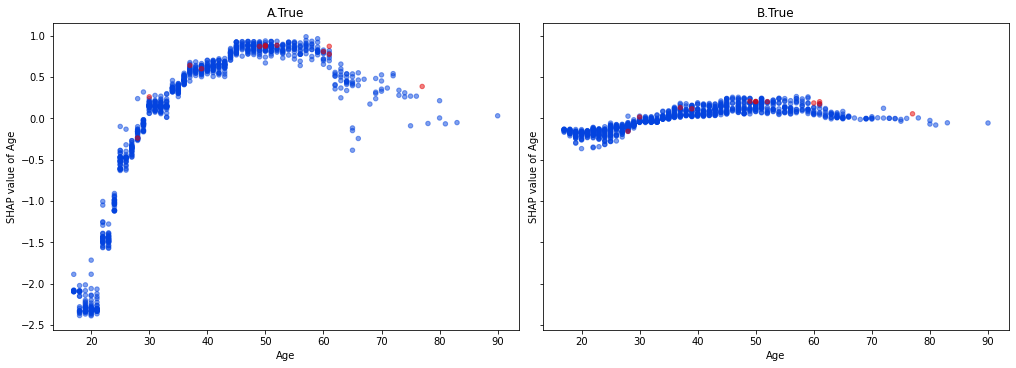

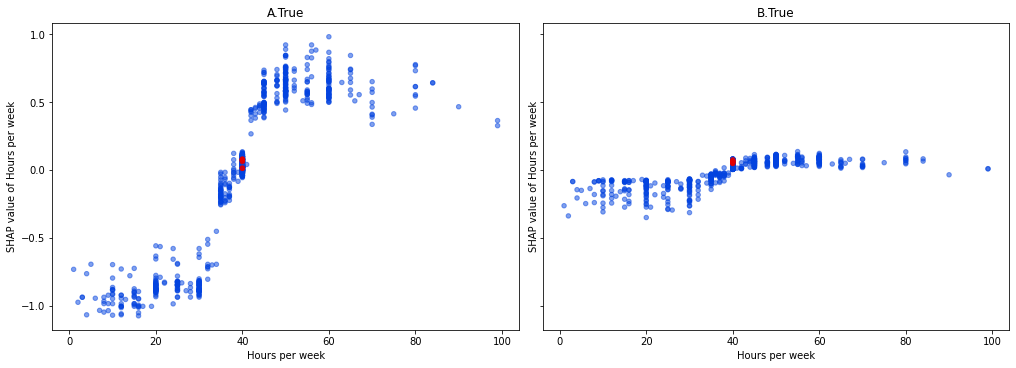

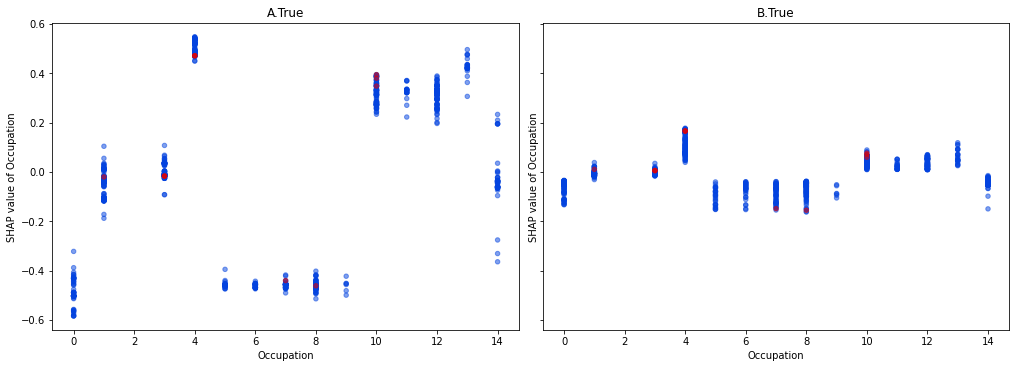

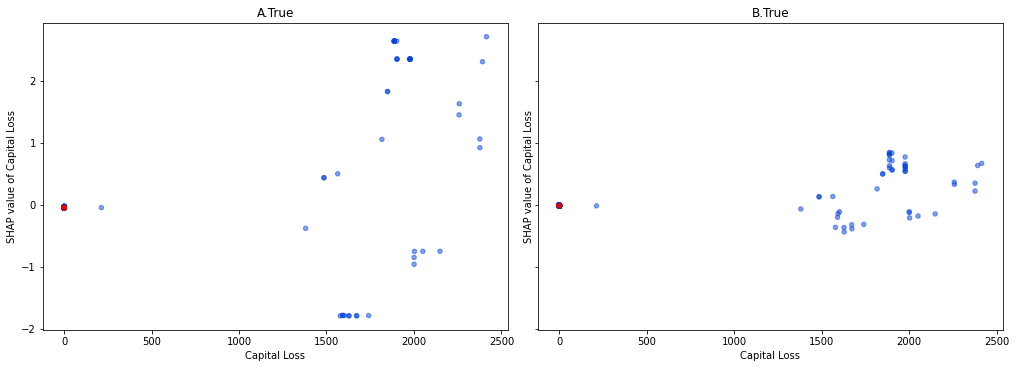

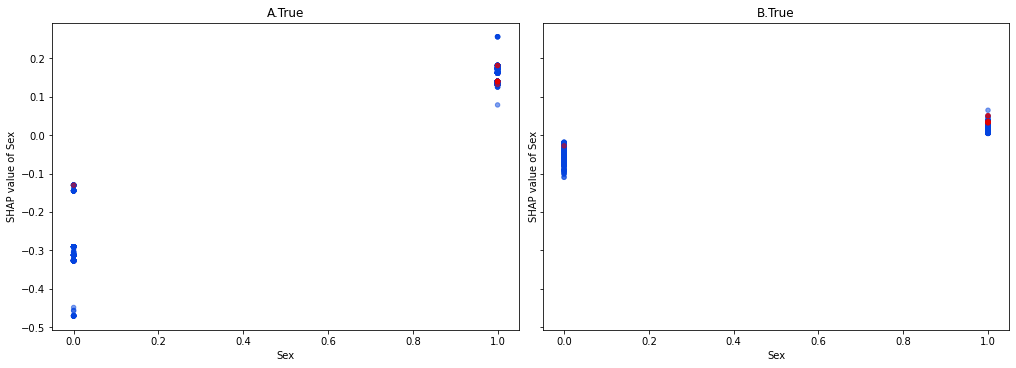

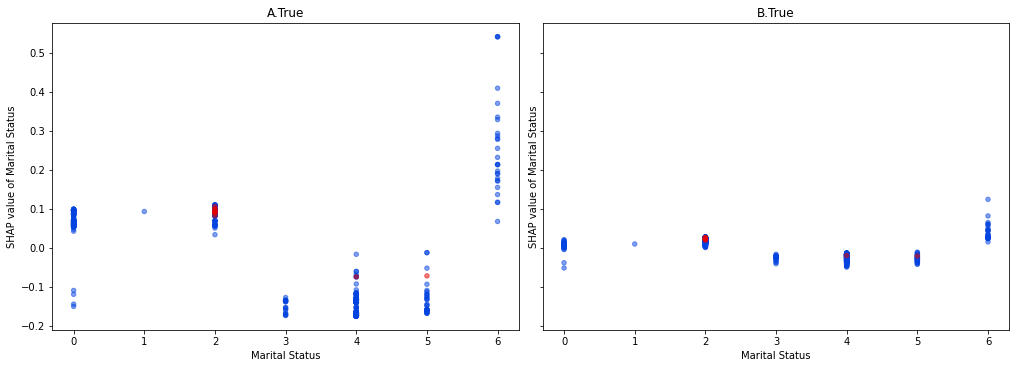

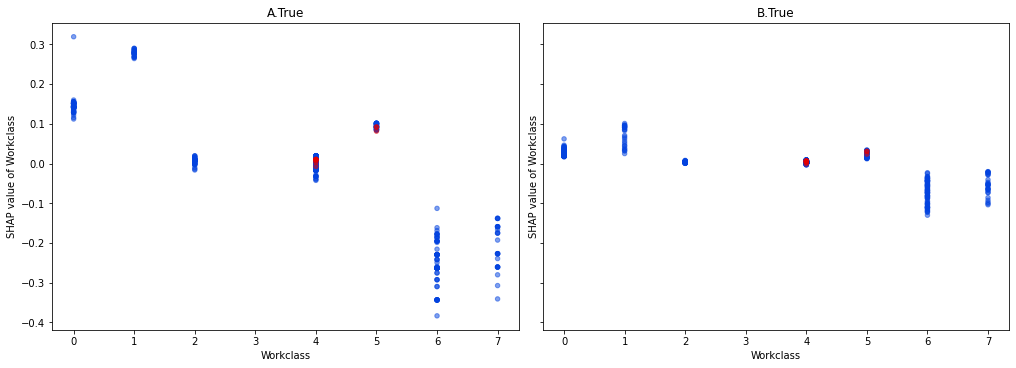

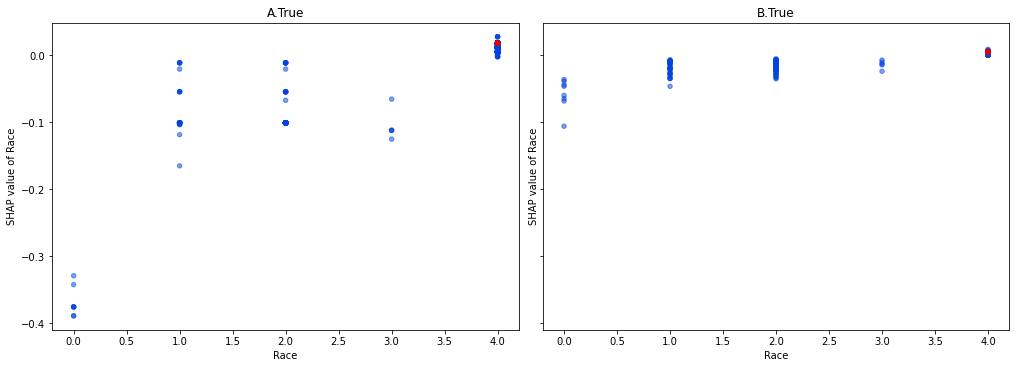

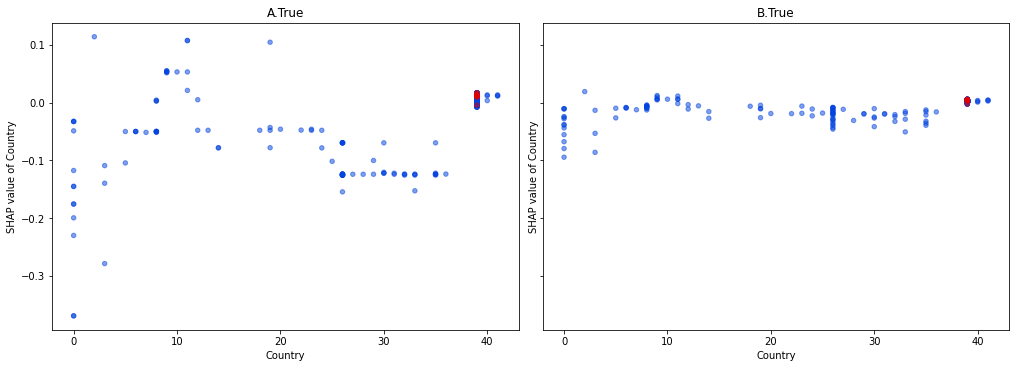

In [18]:
for feature in feature_order:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [4]:
with open('diffclf.test.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

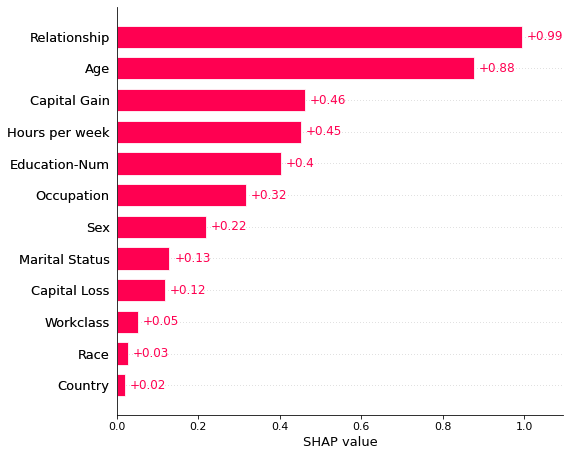

In [5]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

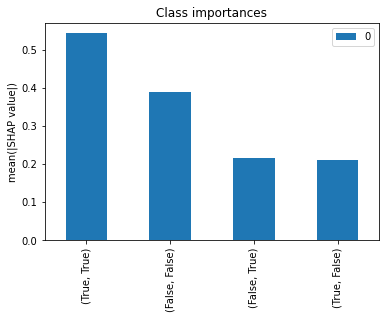

In [6]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [7]:
def plot(feature):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)

In [8]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, type='bin-diffclf', x=x, y=y, alpha=0.5, show=False)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

## Clustering of Class $(False, True)$ SHAP Values

In [9]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 7min 28s, sys: 36.7 s, total: 8min 5s
Wall time: 3min 8s


((False, False)    786
 (True, True)      179
 (False, True)      12
 dtype: int64,
 345.2132491825516)

In [10]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

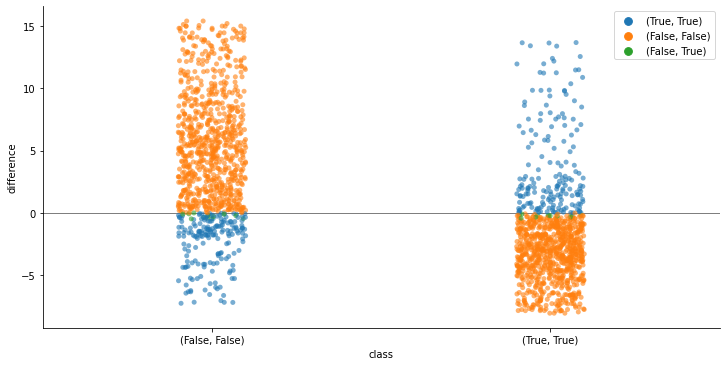

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [11]:
node.plot_outcome_differences()

### Main Node (R)

It's the same cluster node, with slightly different numbers of instances of classes $(False, False)$ and $(True, True)$.

In [12]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (False, False)    786
 (True, True)      138
 (False, True)      12
 dtype: int64,
 145.5470255555808)

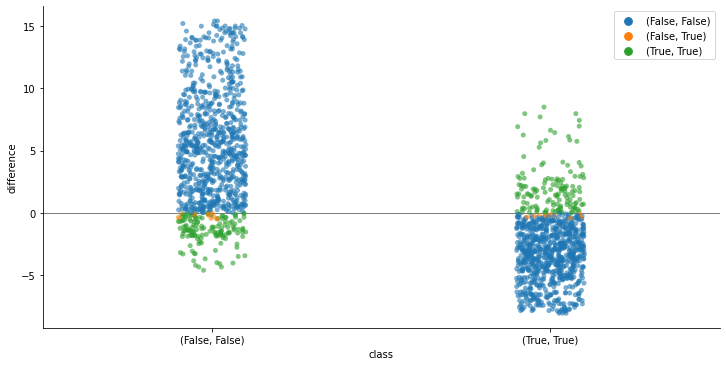

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [13]:
ref_node = node
node.plot_outcome_differences()

In [14]:
feature_it = iter(node.features_with_counterfactuals)

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 12},
 Upper CF: Age == 80.0 --> {'(False, False)': 11, '(True, True)': 1}]


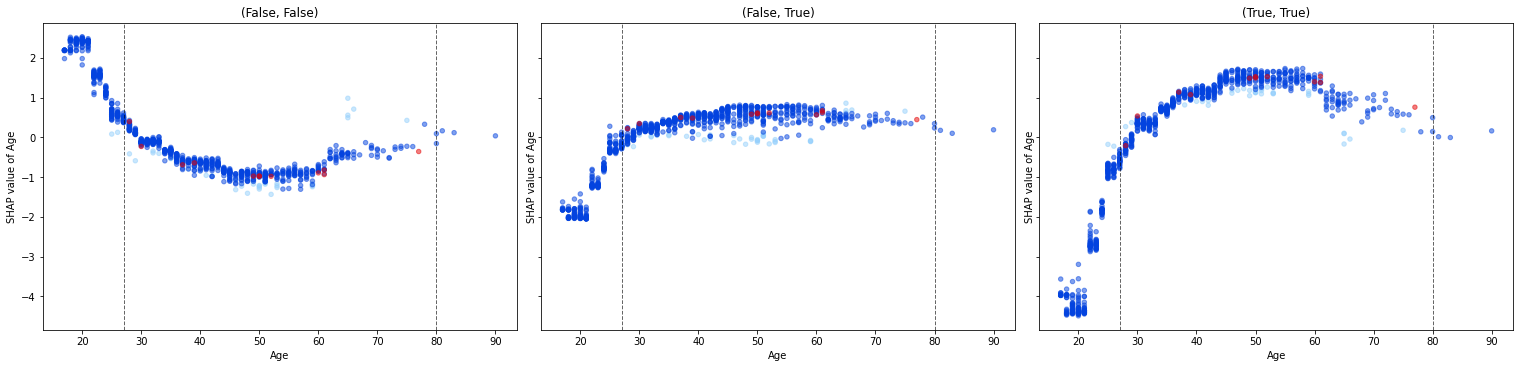

In [15]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 12},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 12}]


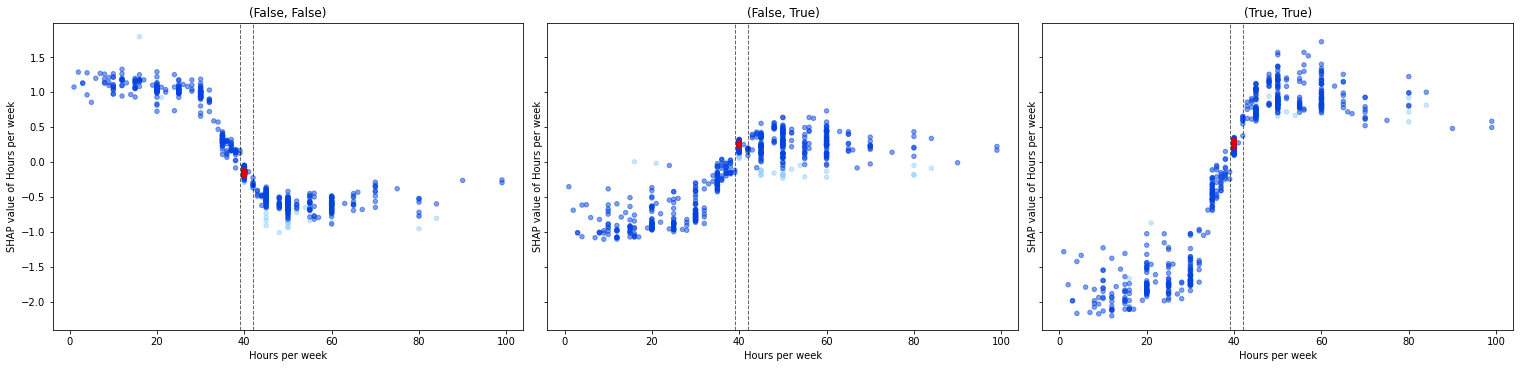

In [16]:
plot(next(feature_it))

9.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 12}]


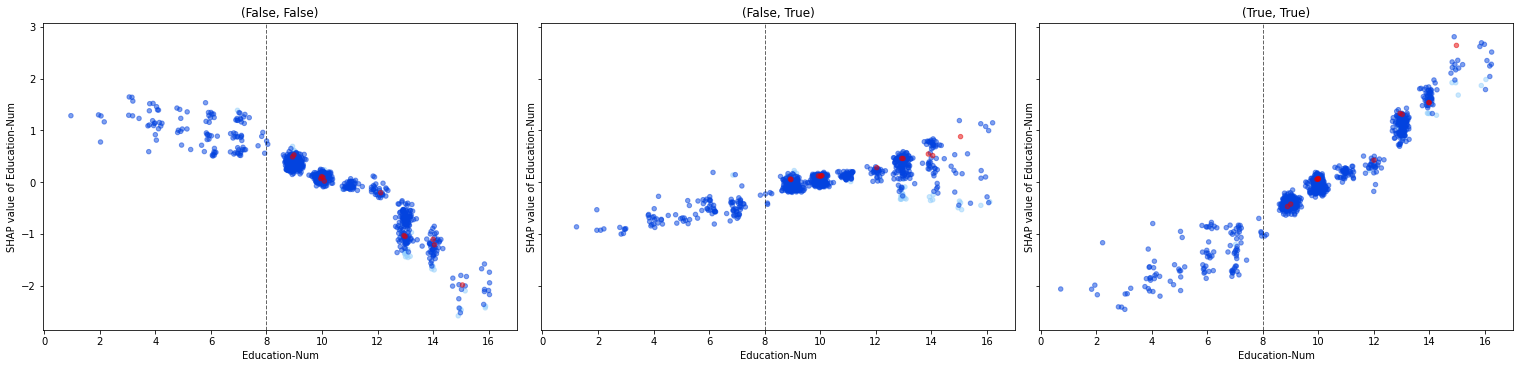

In [17]:
plot(next(feature_it))

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 12}]


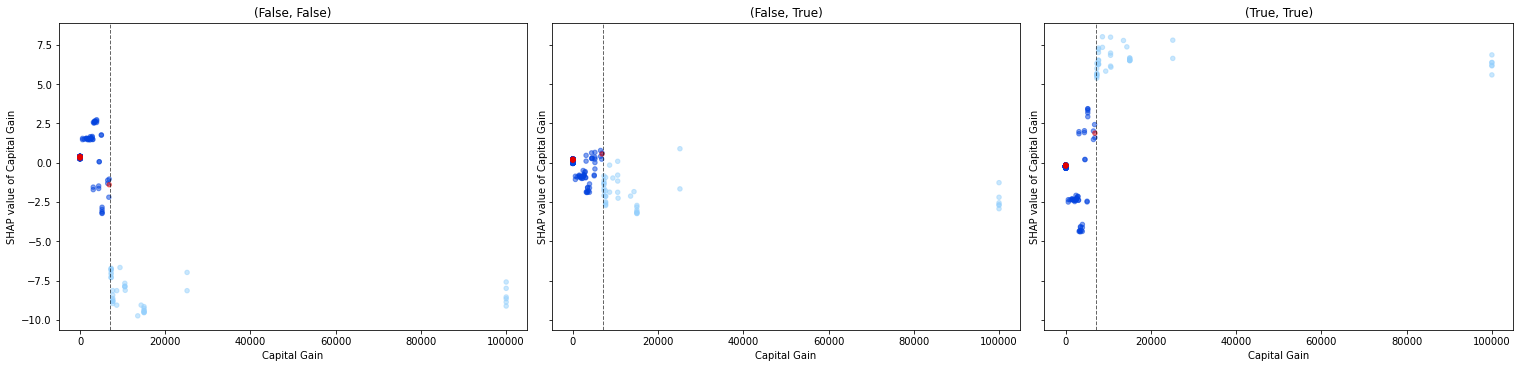

In [18]:
plot(next(feature_it))

Now ranked before Marital Status

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 12}]


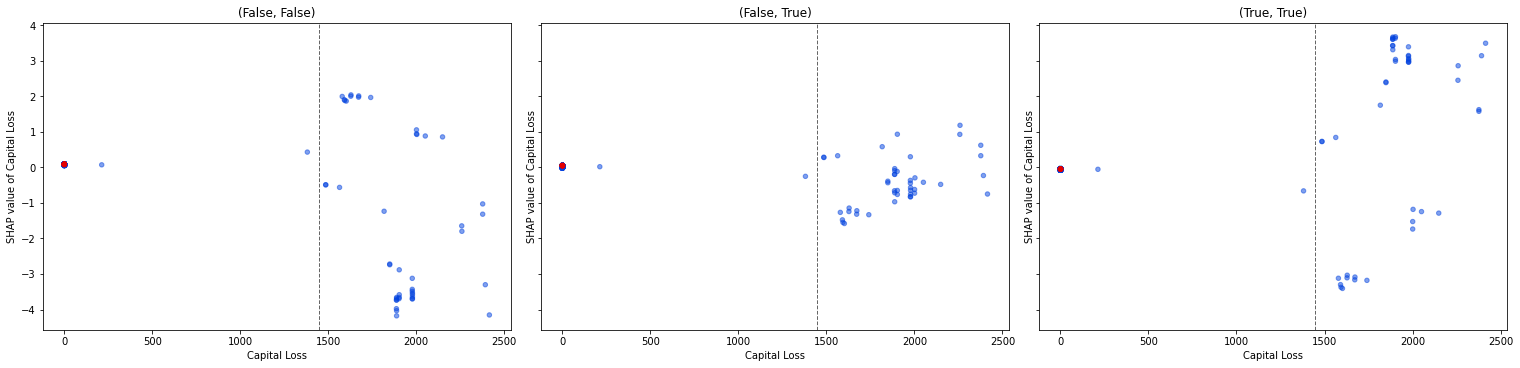

In [19]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 12}]


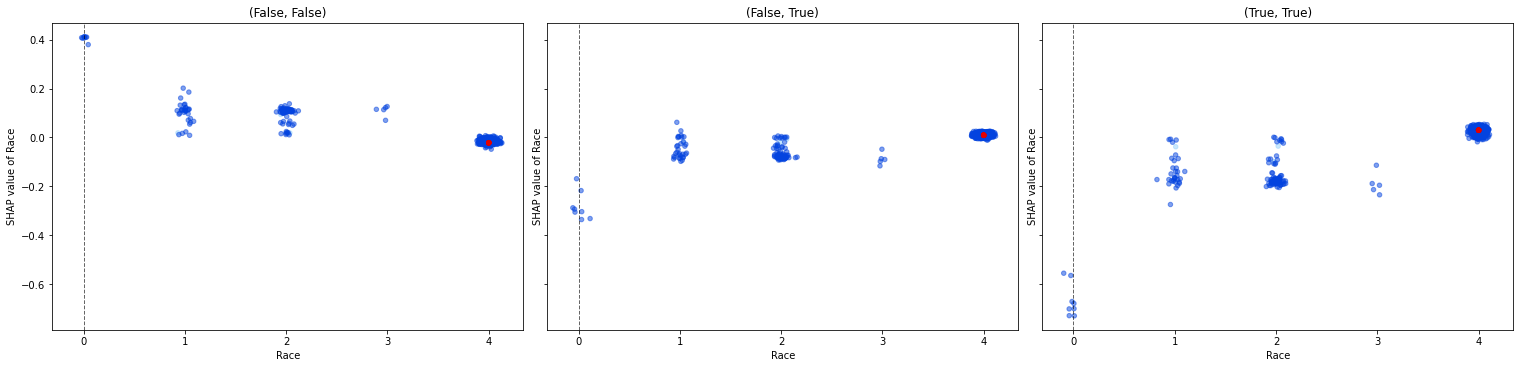

In [20]:
plot(next(feature_it))

27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



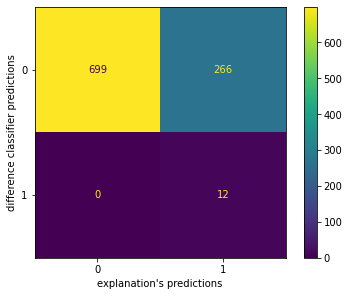

In [21]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.root.evaluate_rules(rule)

In [22]:
explanations_global = [(rule, constraint, instance_indices)]

### Node 1 (RLRLR)

It's the same cluster node, with the count of class $(False, False)$ instances being slightly smaller (170-8)

In [23]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLR,
 (False, False)    162
 (False, True)       2
 (True, True)        2
 dtype: int64,
 51.51314638142301)

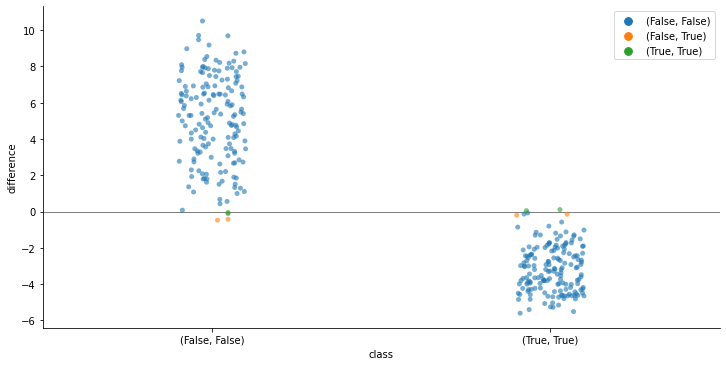

{'(False, False)': '-0.47 to -0.42', '(True, True)': '-0.2 to -0.15'}


In [24]:
ref_node = node
ref_node.plot_outcome_differences()

In [25]:
feature_it = iter(node.features_with_counterfactuals)

Relationship: different, Counterfactual changed from 1 to 4

Relationship == 0.0
[Upper CF: Relationship == 4.0 --> {'(True, True)': 2}]


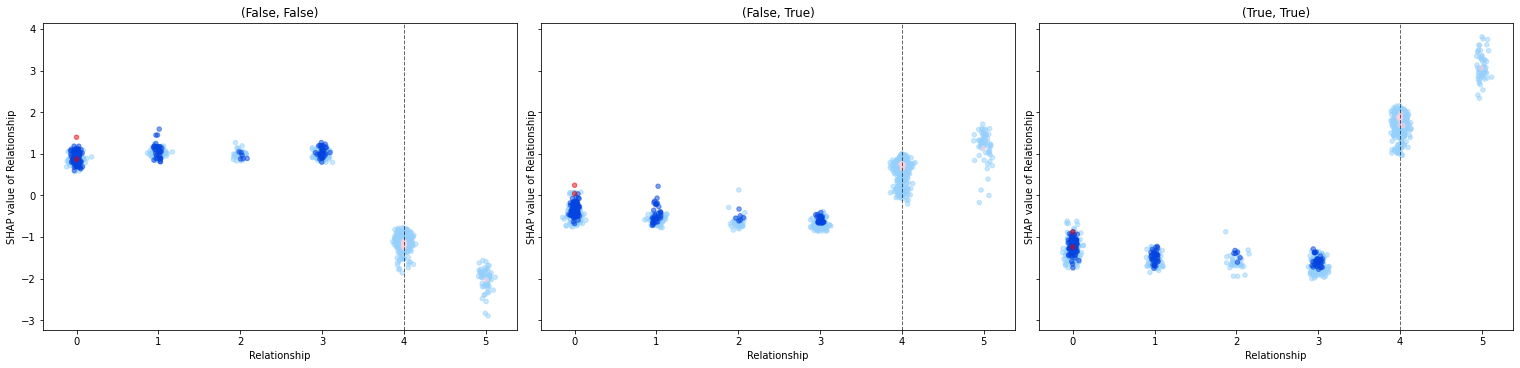

In [26]:
plot(next(feature_it))

similar, was previously ranked after Age, is now before

14.0 <= Education-Num <= 15.0
[Lower CF: Education-Num == 13.0 --> {'(False, False)': 2}]


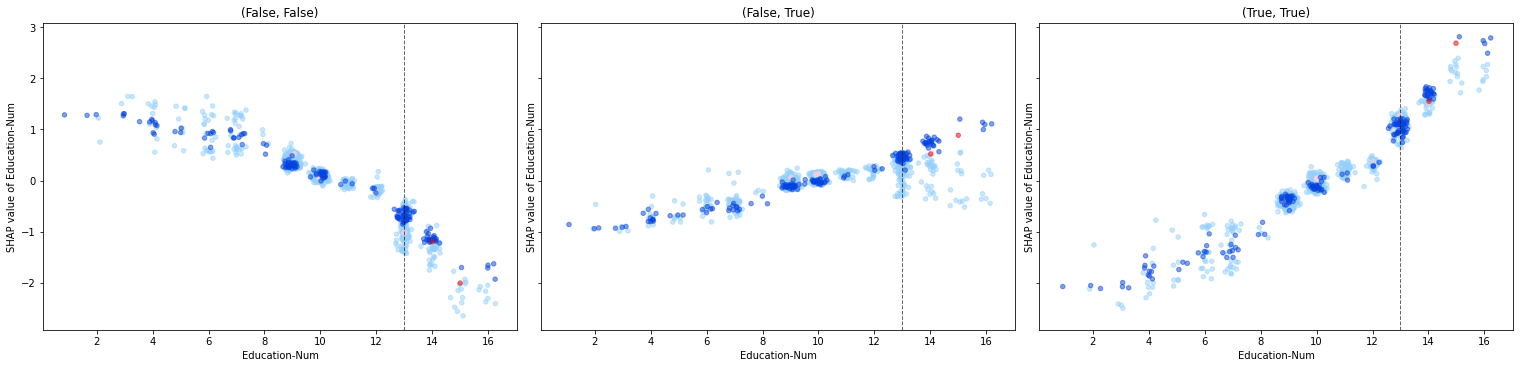

In [27]:
plot(next(feature_it))

Counterfactuals have changed ($\leq 36 \Rightarrow \leq 29$, $\geq 66 \Rightarrow \geq 80$)

39.0 <= Age <= 61.0
[Lower CF: Age == 29.0 --> {'(False, False)': 2},
 Upper CF: Age == 80.0 --> {'(False, False)': 2}]


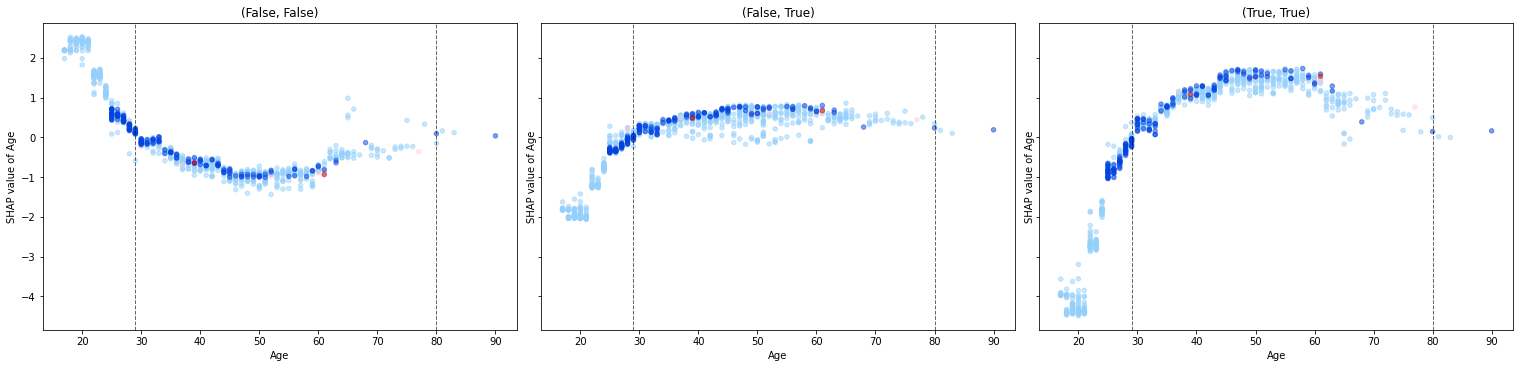

In [28]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 2},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 2}]


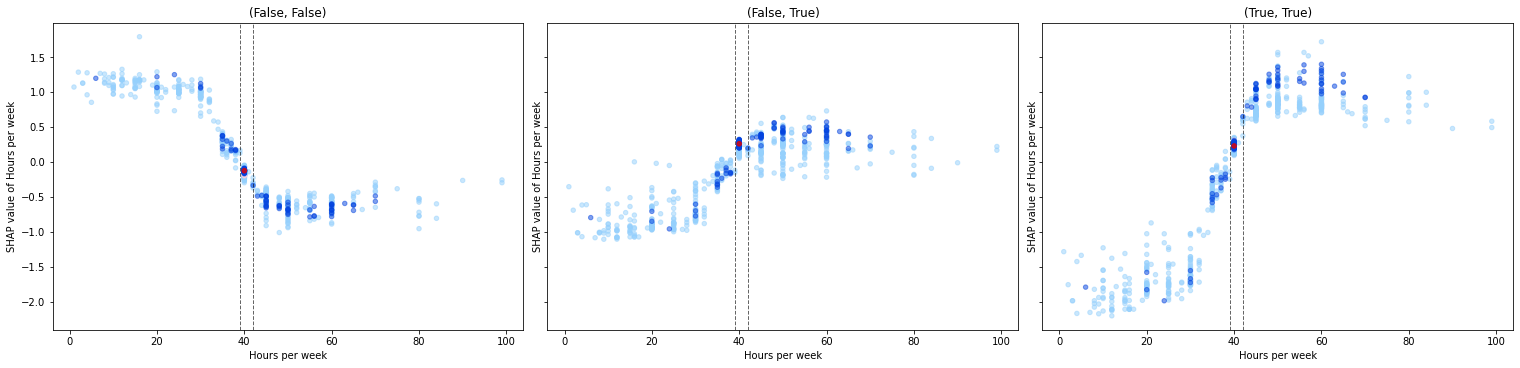

In [29]:
plot(next(feature_it))

Occupation == 10.0
[Lower CF: Occupation == 9.0 --> {'(False, False)': 2},
 Upper CF: Occupation == 14.0 --> {'(False, False)': 2}]


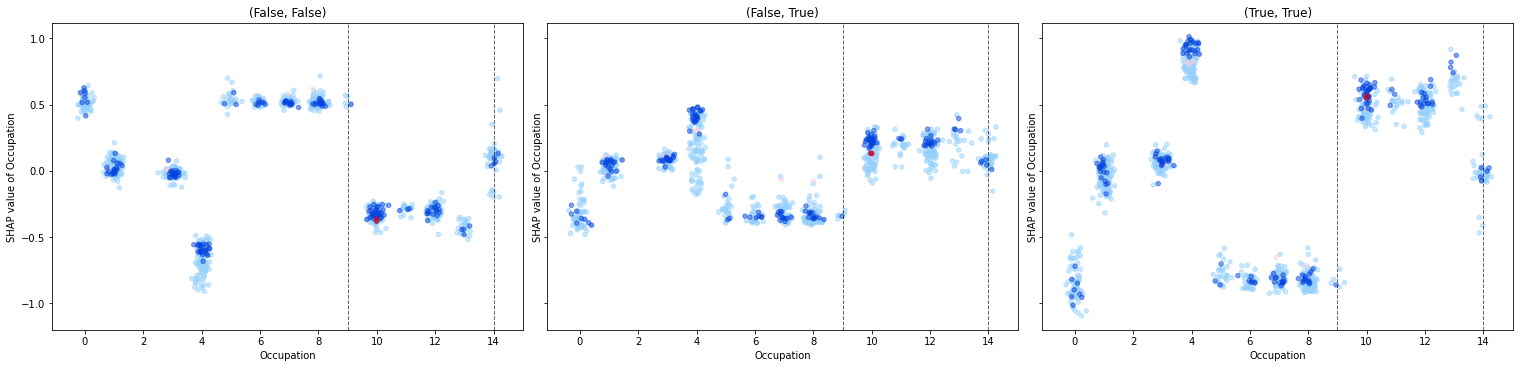

In [30]:
plot(next(feature_it))

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 2}]


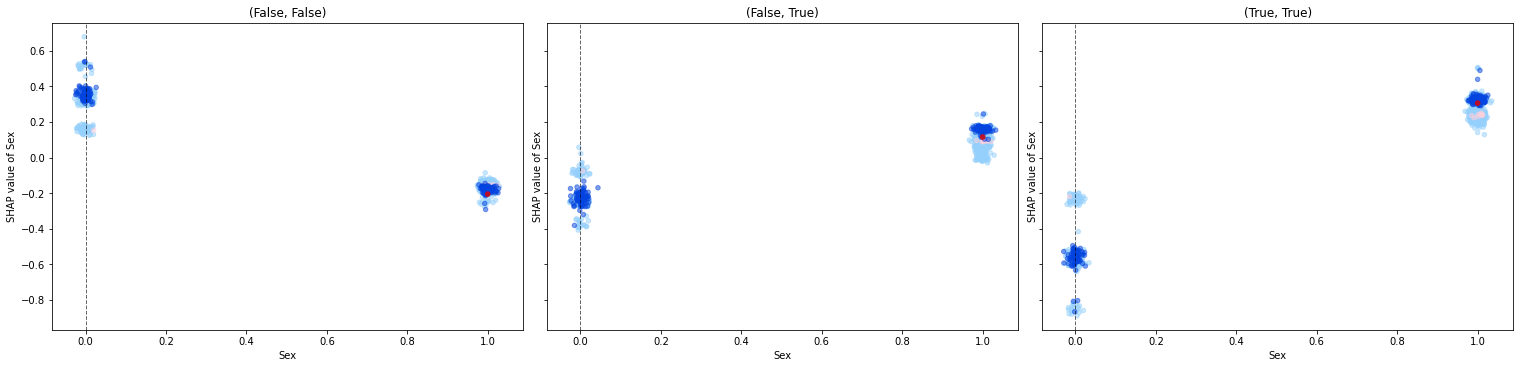

In [31]:
plot(next(feature_it))

Capital Gain <= 6849.0
[Upper CF: Capital Gain == 7074.0 --> {'(True, True)': 2}]


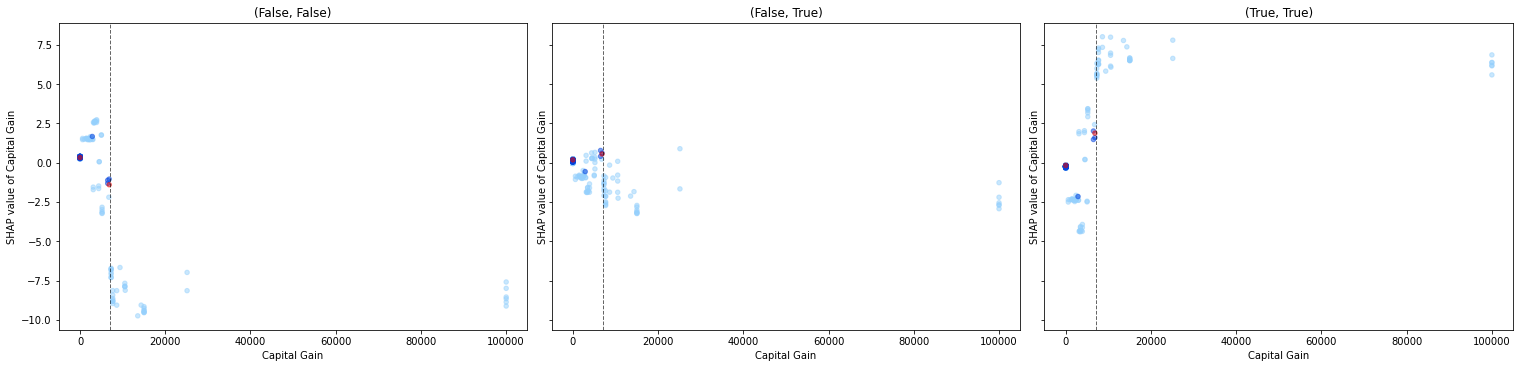

In [32]:
plot(next(feature_it))

Still, the local performance is equal.

Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       164
        True       0.50      1.00      0.67         2

    accuracy                           0.99       166
   macro avg       0.75      0.99      0.83       166
weighted avg       0.99      0.99      0.99       166



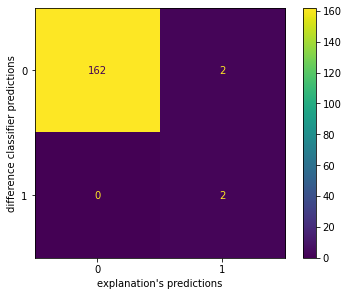

In [33]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Education-Num', 'Hours per week', 'Occupation', 'Sex', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

In [34]:
explanations_l1 = [(rule, constraint, instance_indices)]

### Node 2 (RRRRR)

In [35]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRR,
 (False, False)    178
 (True, True)      103
 (False, True)      10
 dtype: int64,
 33.98983567154949)

There is the same number of instances classified differently, but the cluster node isn't the same. Instance counts are a bit different: $(False, False)$ has 27 more, $(True, True)$ has 7 more.

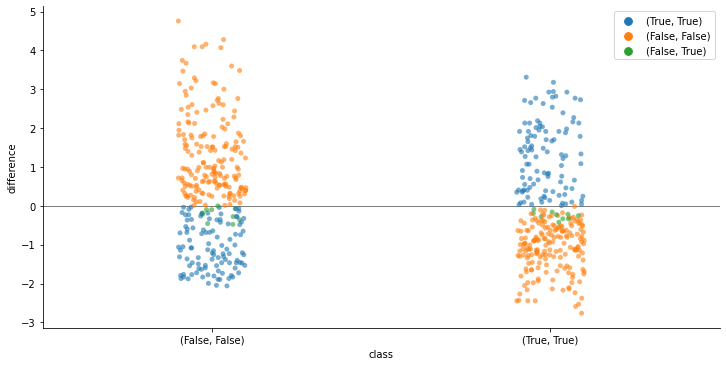

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.09'}


In [36]:
ref_node = node
ref_node.plot_outcome_differences()

In [37]:
feature_it = iter(node.features_with_counterfactuals)

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 10}]


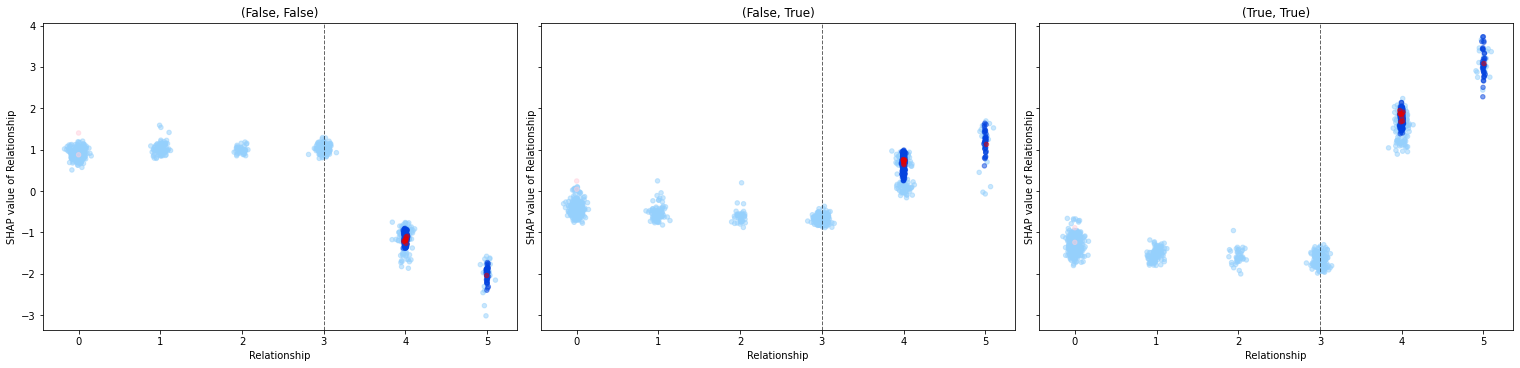

In [38]:
plot(next(feature_it))

28.0 <= Age <= 77.0
[Lower CF: Age == 27.0 --> {'(False, False)': 10},
 Upper CF: Age == 80.0 --> {'(False, False)': 9, '(True, True)': 1}]


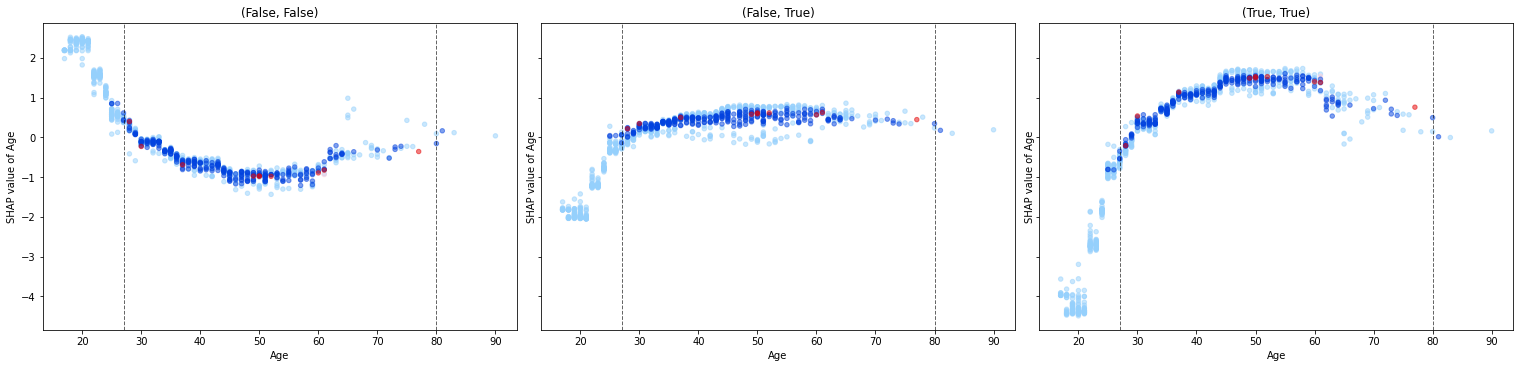

In [39]:
plot(next(feature_it))

9.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 10},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 10}]


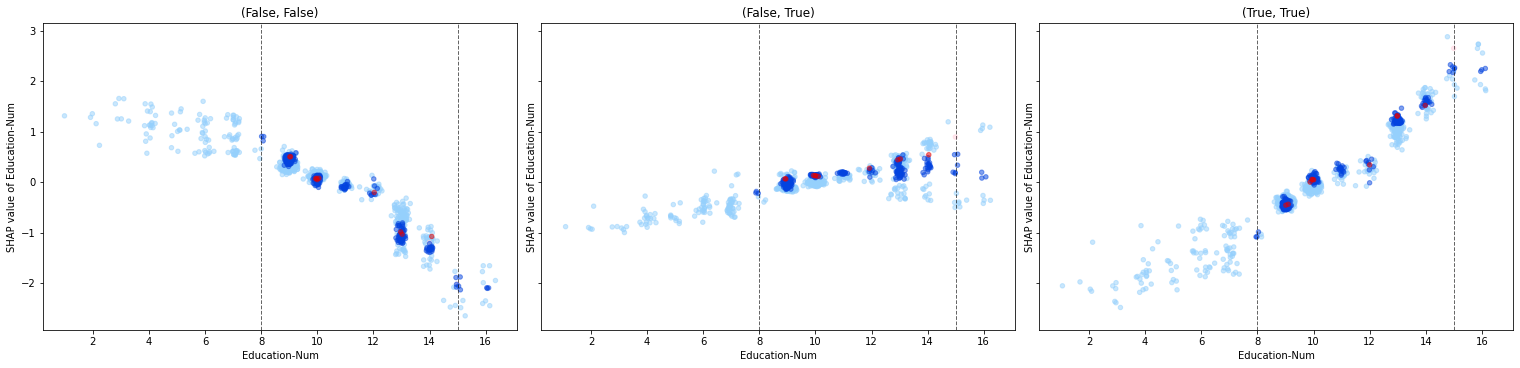

In [40]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 10},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 10}]


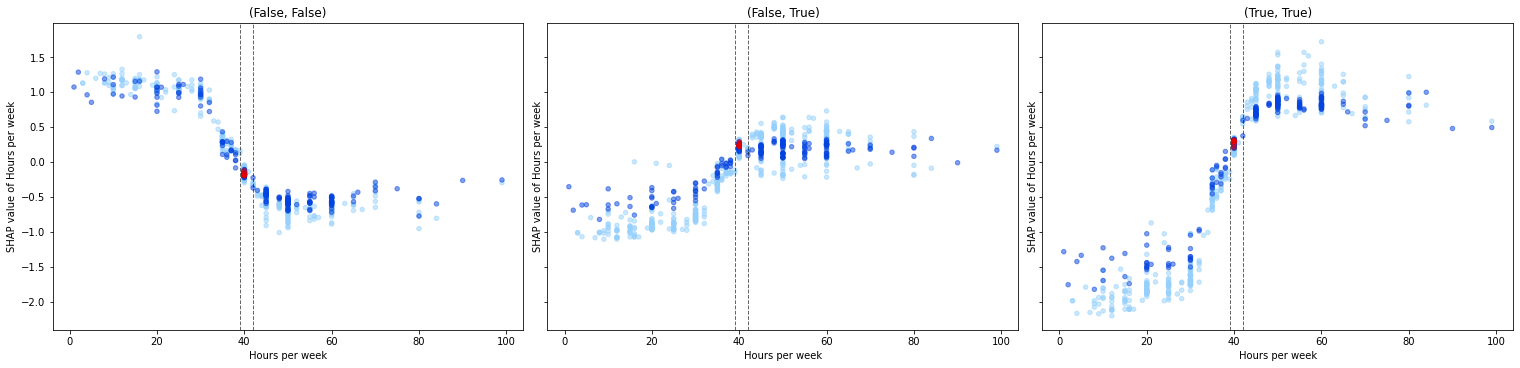

In [41]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 10}]


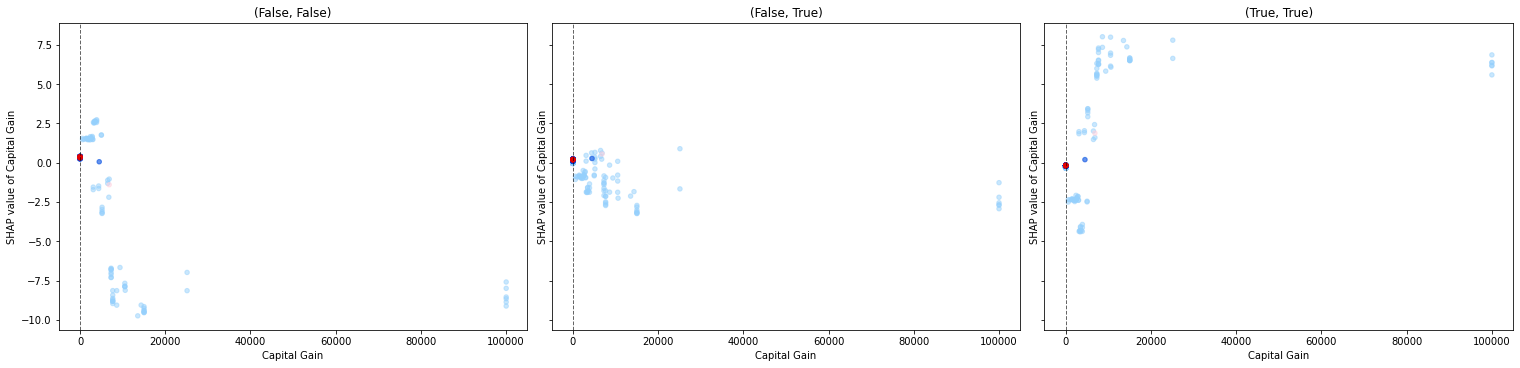

In [42]:
plot(next(feature_it))

Now ranked before Race

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 10}]


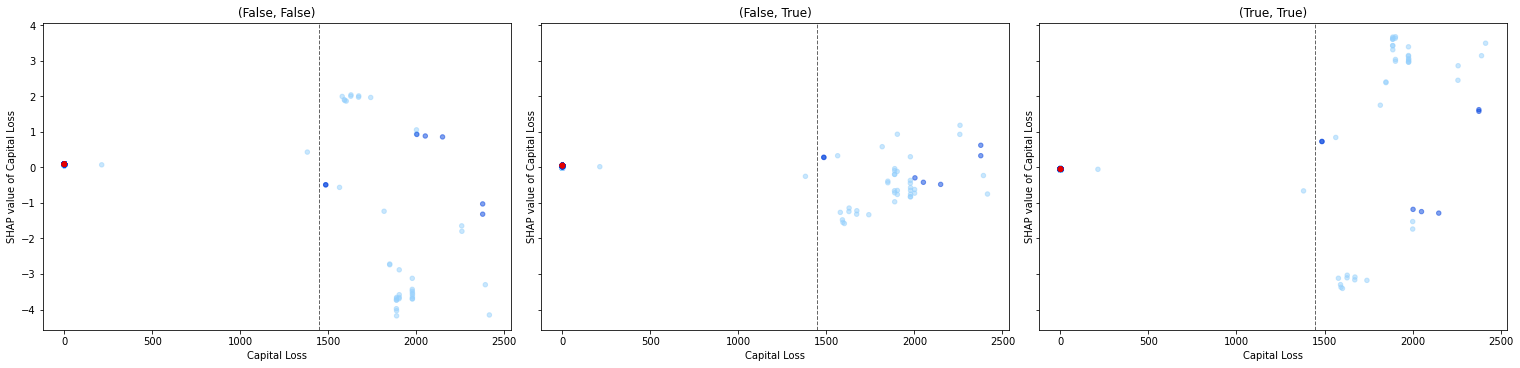

In [43]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 10}]


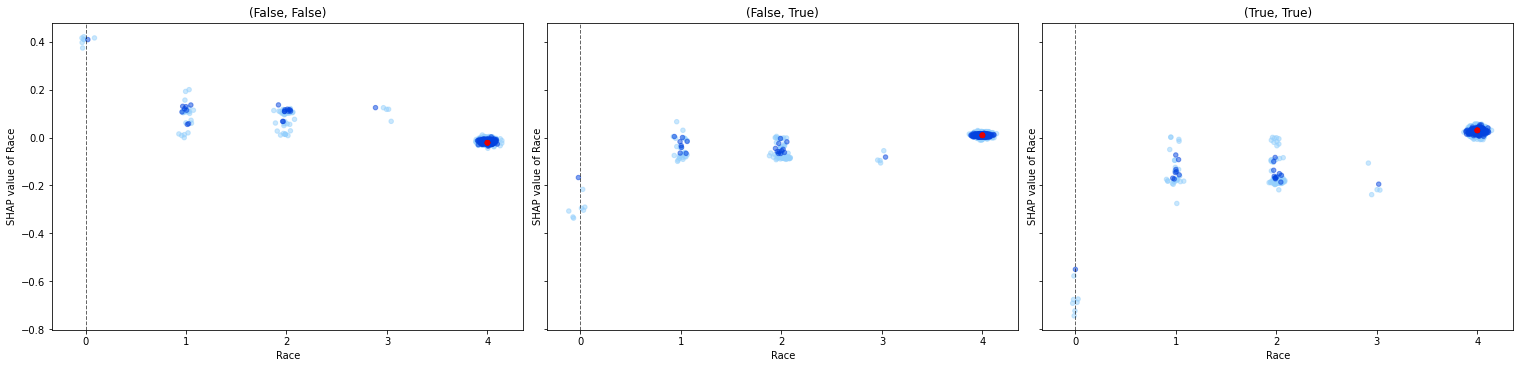

In [44]:
plot(next(feature_it))

Marital Status has no CF here

Still the same performance

Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0
              precision    recall  f1-score   support

       False       1.00      0.62      0.77       281
        True       0.09      1.00      0.16        10

    accuracy                           0.64       291
   macro avg       0.54      0.81      0.46       291
weighted avg       0.97      0.64      0.75       291



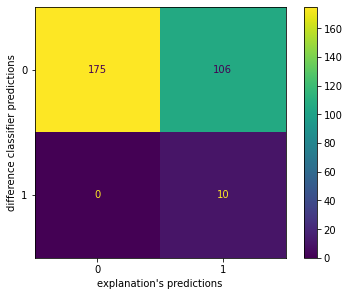

In [45]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain')
print(rule)
node.evaluate_rules(rule)

In [46]:
explanations_l1.append((rule, constraint, instance_indices))

### Node 2.1 (RRRRRL)

In [47]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRL,
 (True, True)      65
 (False, False)     7
 (False, True)      3
 dtype: int64,
 14.368012741572981)

Although the cluster node is different, it has the same numbers of instances per class.

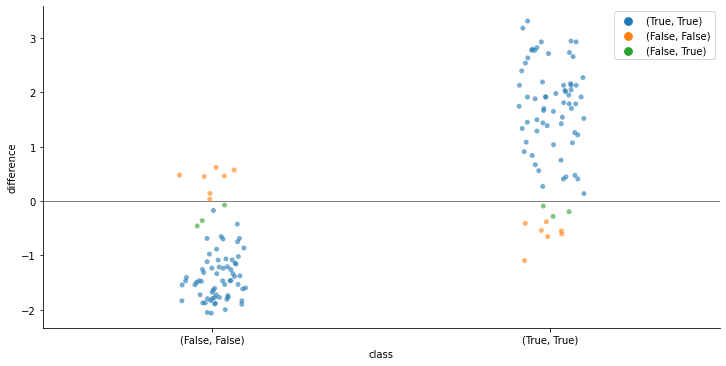

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.28 to -0.09'}


In [48]:
ref_node = node
ref_node.plot_outcome_differences()

In [49]:
feature_it = iter(node.features_with_counterfactuals)

4.0 <= Relationship
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3}]


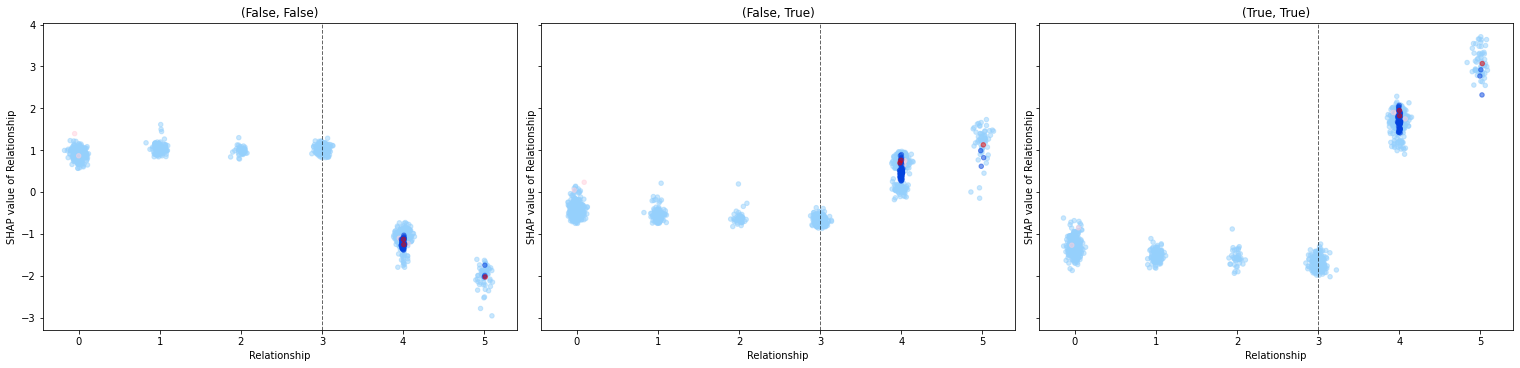

In [50]:
plot(next(feature_it))

13.0 <= Education-Num <= 14.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3},
 Upper CF: Education-Num == 15.0 --> {'(True, True)': 3}]


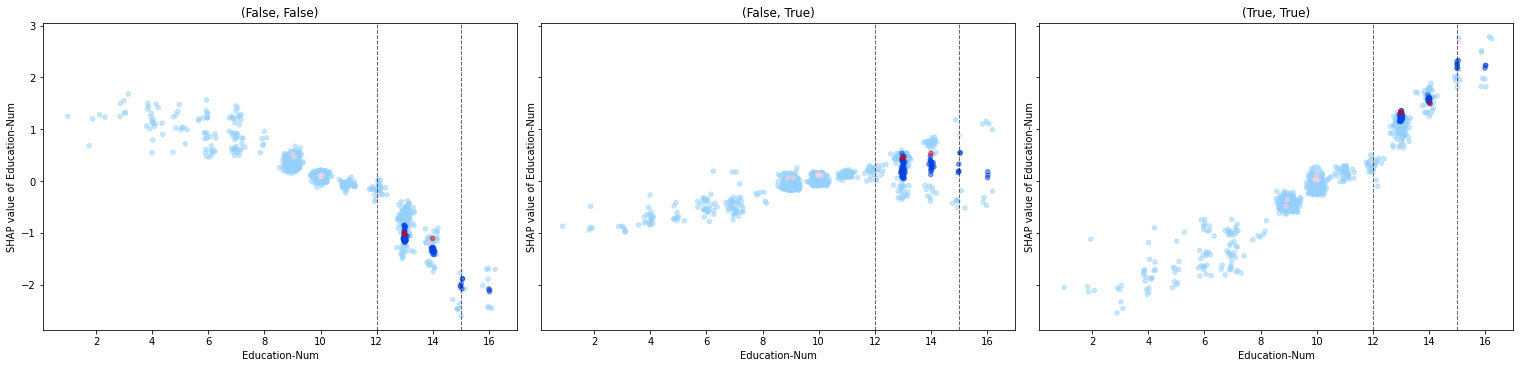

In [51]:
plot(next(feature_it))

Upper CF now lower

28.0 <= Age <= 37.0
[Lower CF: Age == 27.0 --> {'(False, False)': 3},
 Upper CF: Age == 40.0 --> {'(True, True)': 3}]


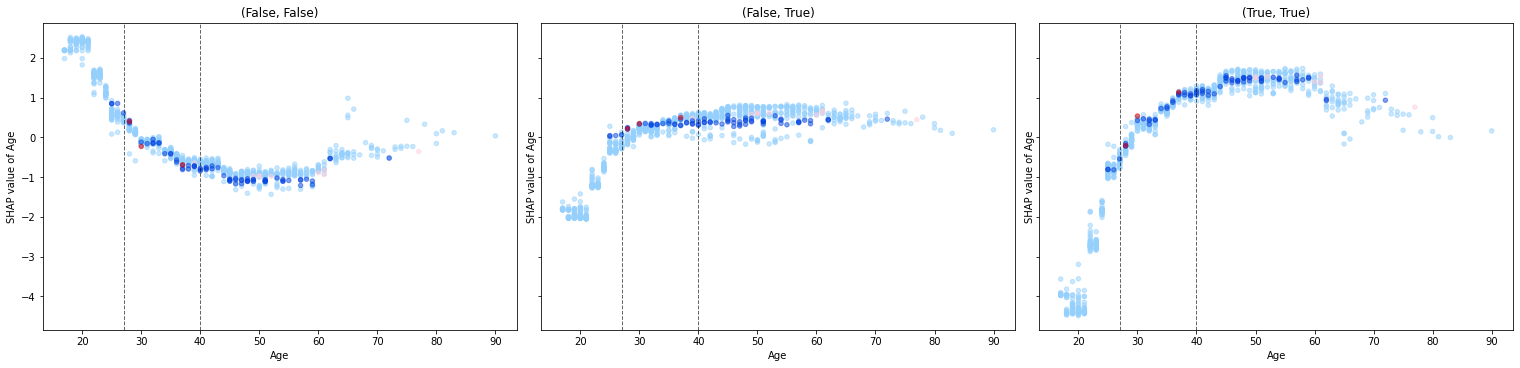

In [52]:
plot(next(feature_it))

now ranked before Occupation

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 3}]


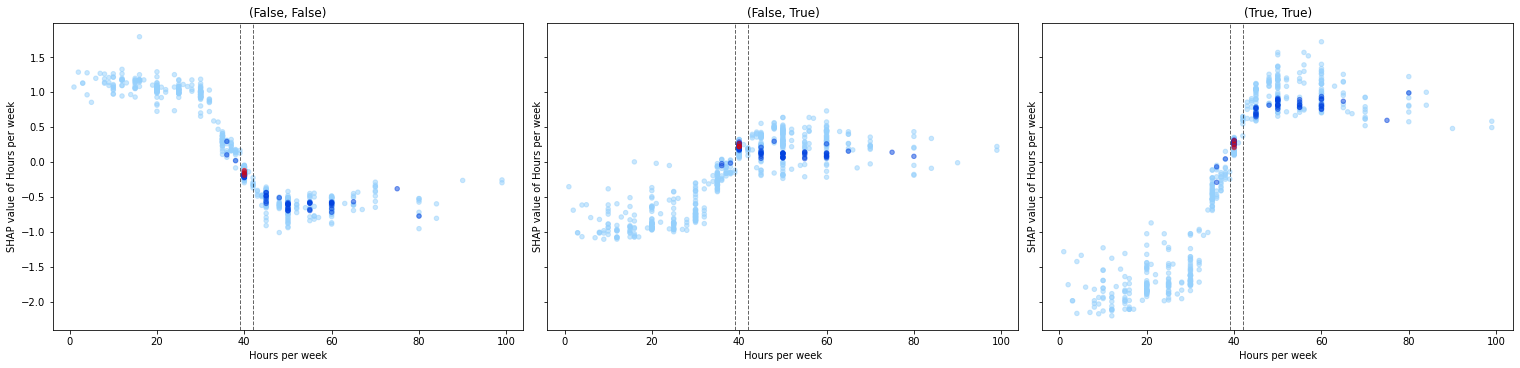

In [53]:
plot(next(feature_it))

7.0 <= Occupation <= 10.0
[Lower CF: Occupation == 3.0 --> {'(True, True)': 2, '(False, False)': 1}]


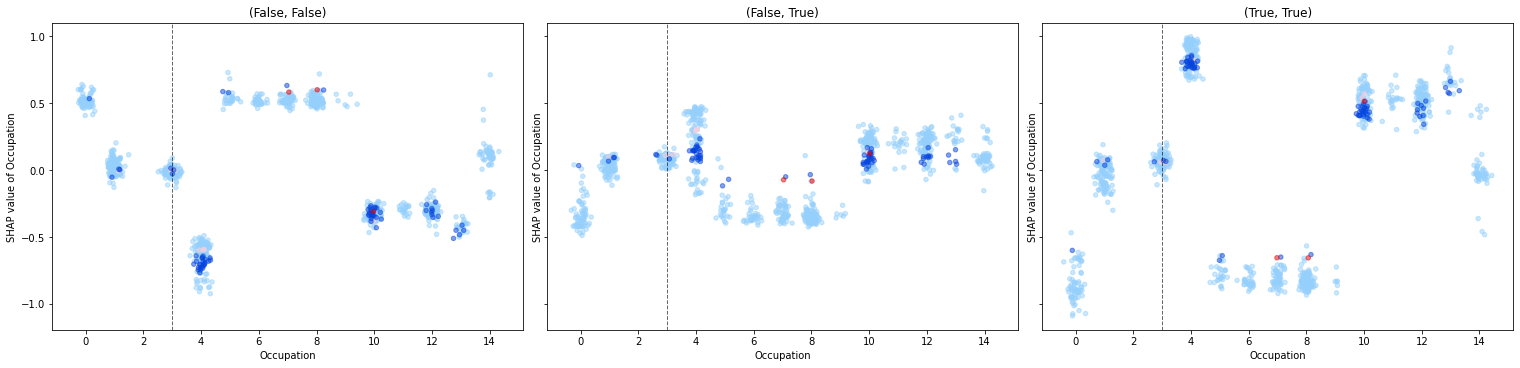

In [54]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


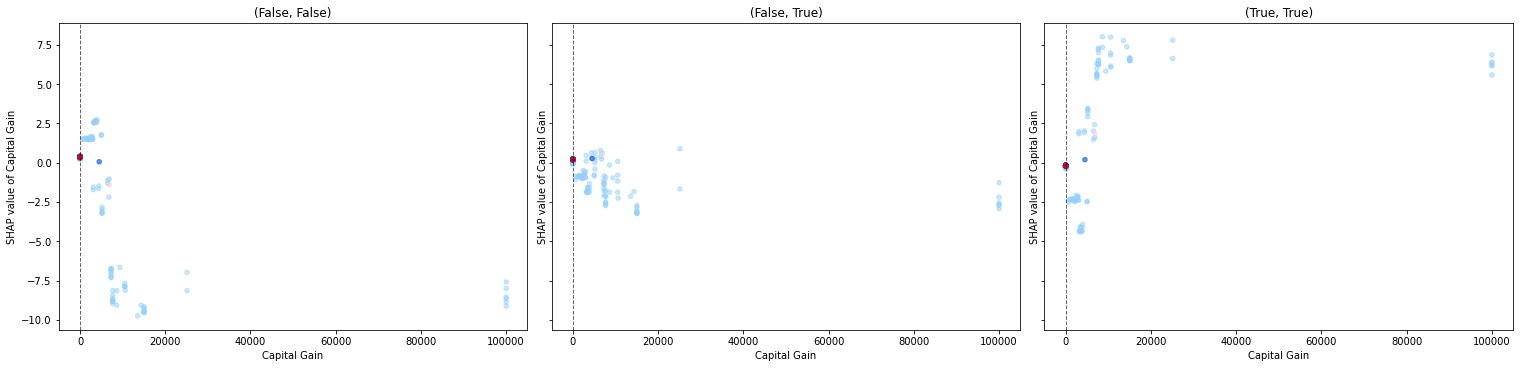

In [55]:
plot(next(feature_it))

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 3}]


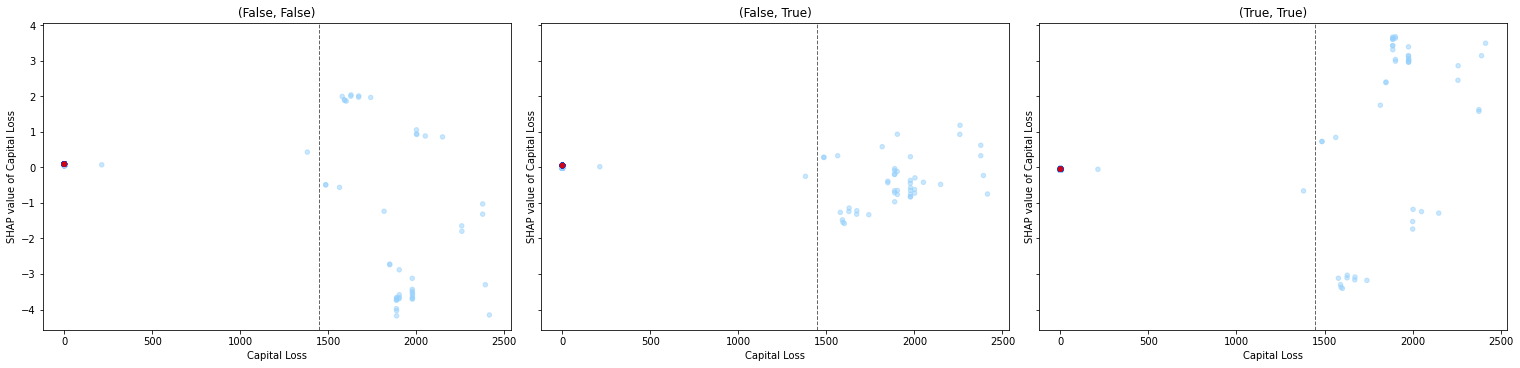

In [56]:
plot(next(feature_it))

Marital Status has no CF anymore, instead Workclass has

Workclass == 4.0
[Lower CF: Workclass == 1.0 --> {'(True, True)': 3}]


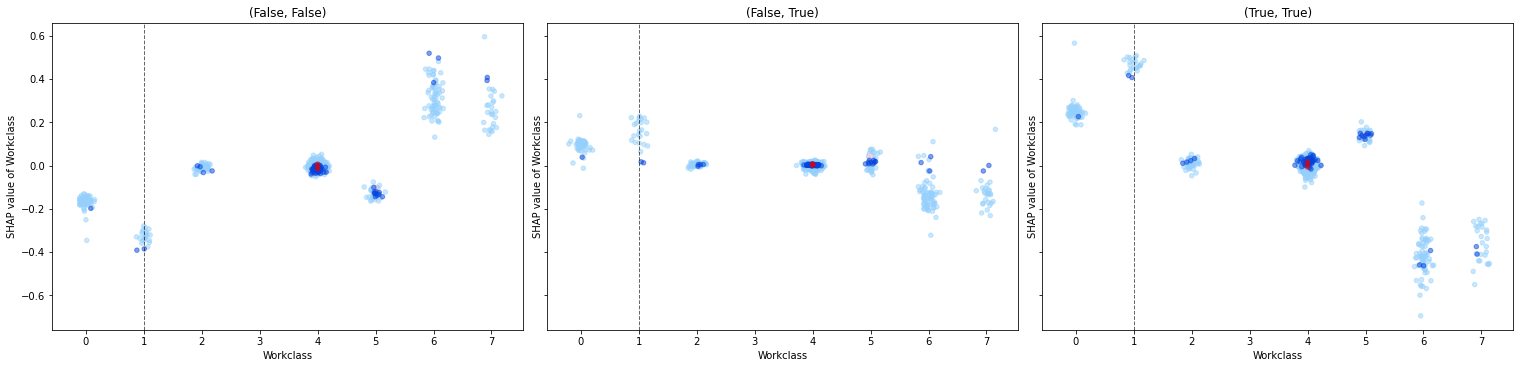

In [57]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 3}]


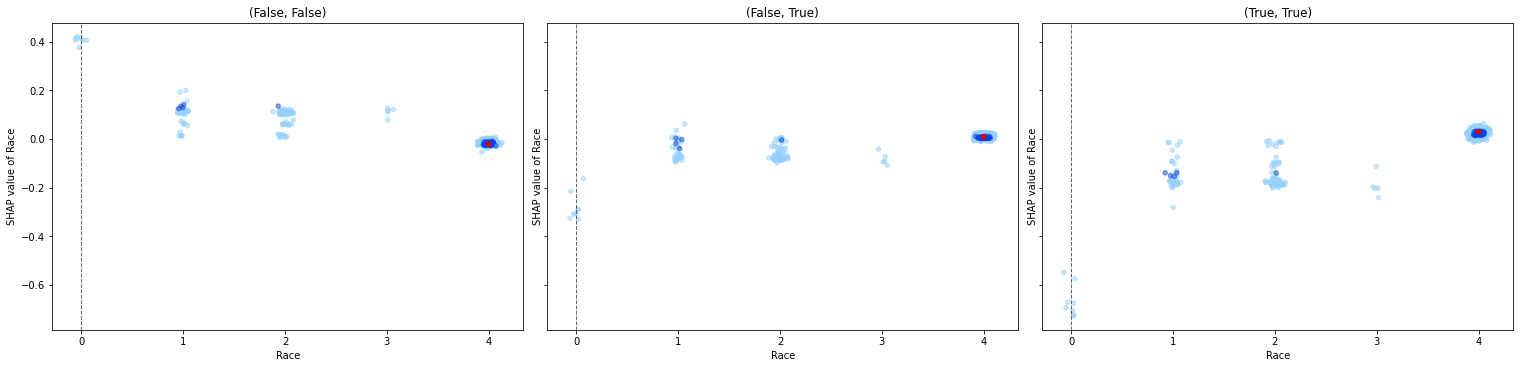

In [58]:
plot(next(feature_it))

This leads to better performance

Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 39.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and Workclass > 1.0
              precision    recall  f1-score   support

       False       1.00      0.92      0.96        72
        True       0.33      1.00      0.50         3

    accuracy                           0.92        75
   macro avg       0.67      0.96      0.73        75
weighted avg       0.97      0.92      0.94        75



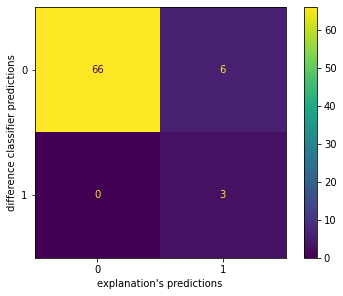

In [59]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Education-Num', 'Age', 'Hours per week', 'Capital Gain', 'Workclass')
print(rule)
node.evaluate_rules(rule)

In [60]:
explanations_l2 = [explanations_l1[0]]
explanations_l2.append((rule, constraint, instance_indices))

### Node 2.2 (RRRRRRRRL)

In [61]:
node = node.root.get('RRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRRRRL,
 (False, False)    102
 (True, True)       28
 (False, True)       7
 dtype: int64,
 8.355443986900394)

The number of instances in the difference class is the same, but those of $(False, False)$ is higher by 13, those of $(True, True)$ is lower by 2.

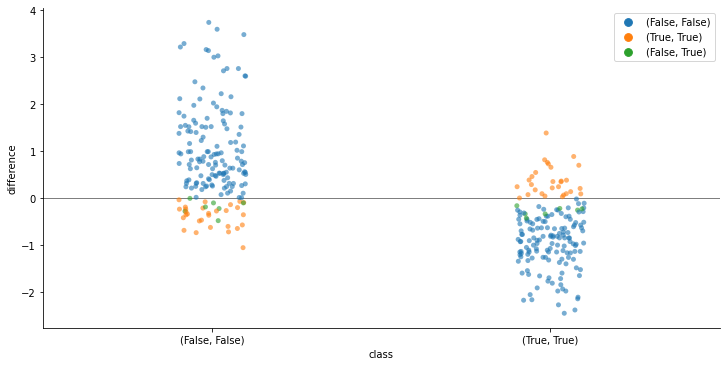

{'(False, False)': '-0.48 to -0.0', '(True, True)': '-0.42 to -0.16'}


In [62]:
ref_node = node.parent
ref_node.plot_outcome_differences()

In [63]:
feature_it = iter(node.features_with_counterfactuals)

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 7}]


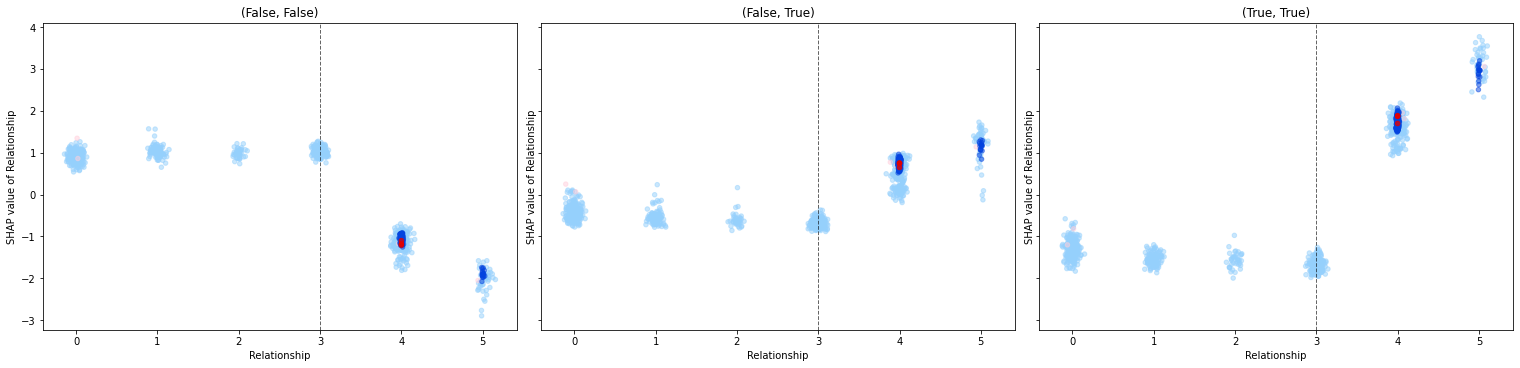

In [64]:
plot(next(feature_it))

49.0 <= Age <= 77.0
[Lower CF: Age == 33.0 --> {'(False, False)': 7},
 Upper CF: Age == 80.0 --> {'(False, False)': 7}]


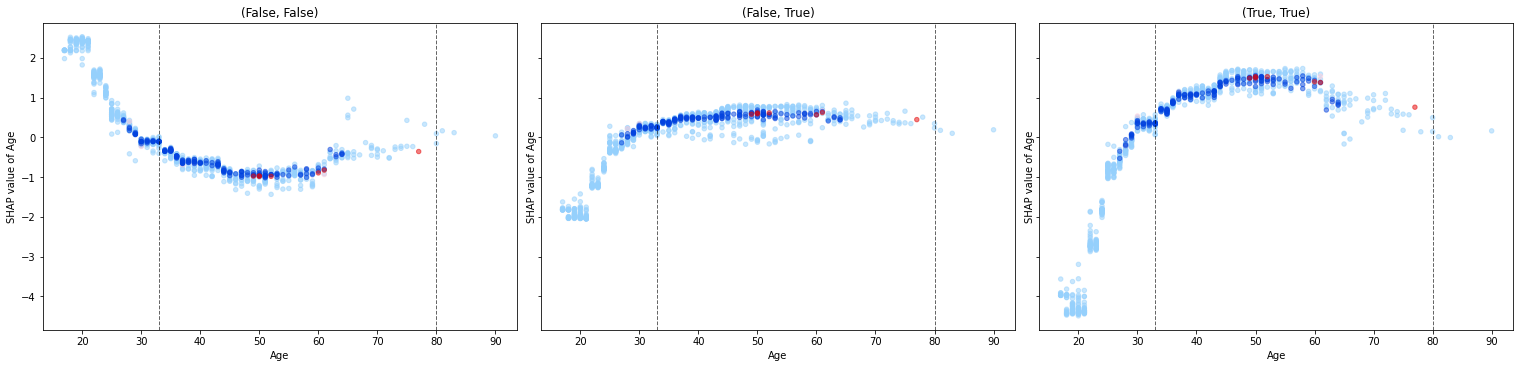

In [65]:
plot(next(feature_it))

Hours per week == 40.0
[Lower CF: Hours per week == 39.0 --> {'(False, False)': 7},
 Upper CF: Hours per week == 42.0 --> {'(True, True)': 7}]


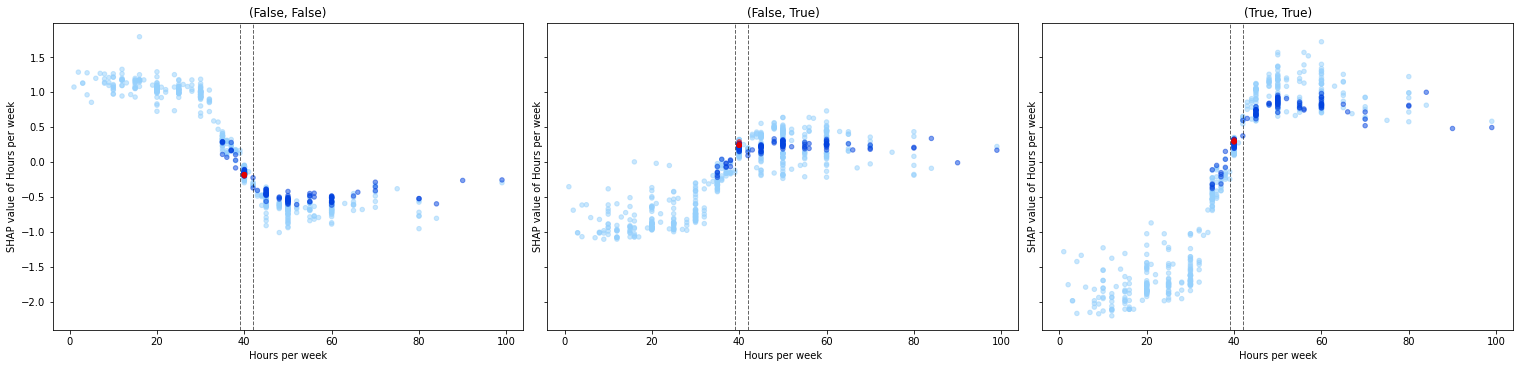

In [66]:
plot(next(feature_it))

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 7}]


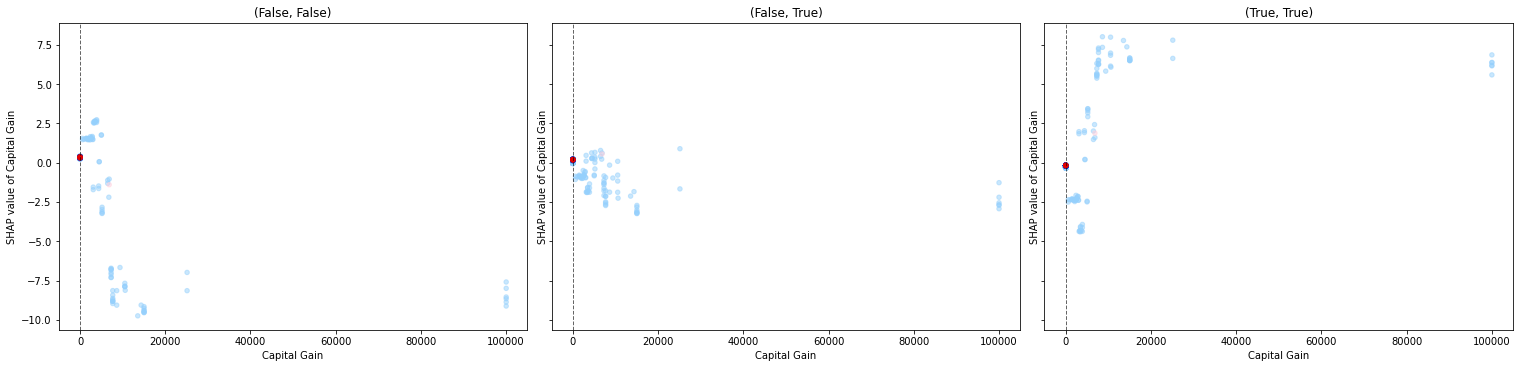

In [67]:
plot(next(feature_it))

1.0 <= Occupation <= 4.0
[Upper CF: Occupation == 5.0 --> {'(False, False)': 7}]


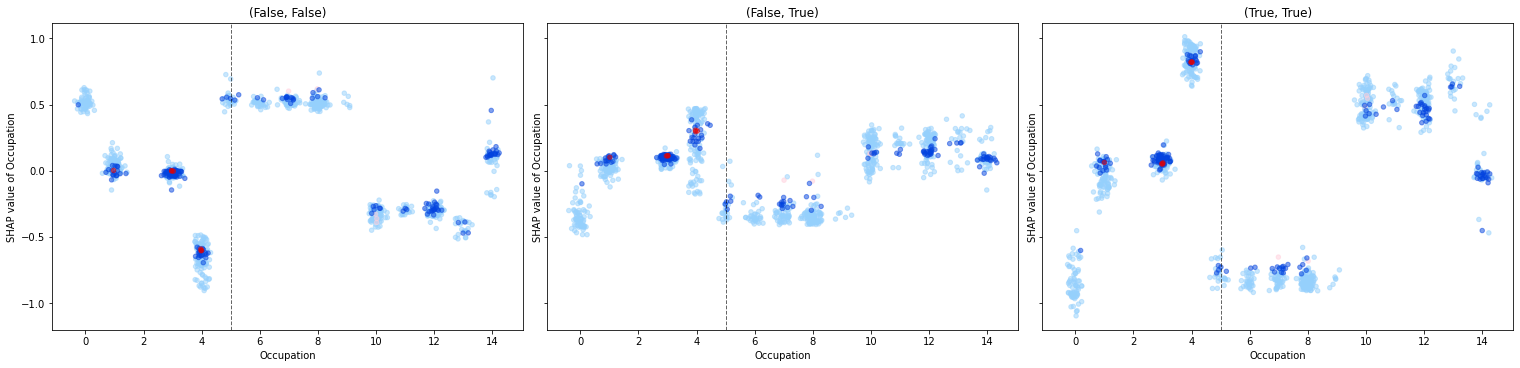

In [68]:
plot(next(feature_it))

9.0 <= Education-Num <= 12.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 7},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 7}]


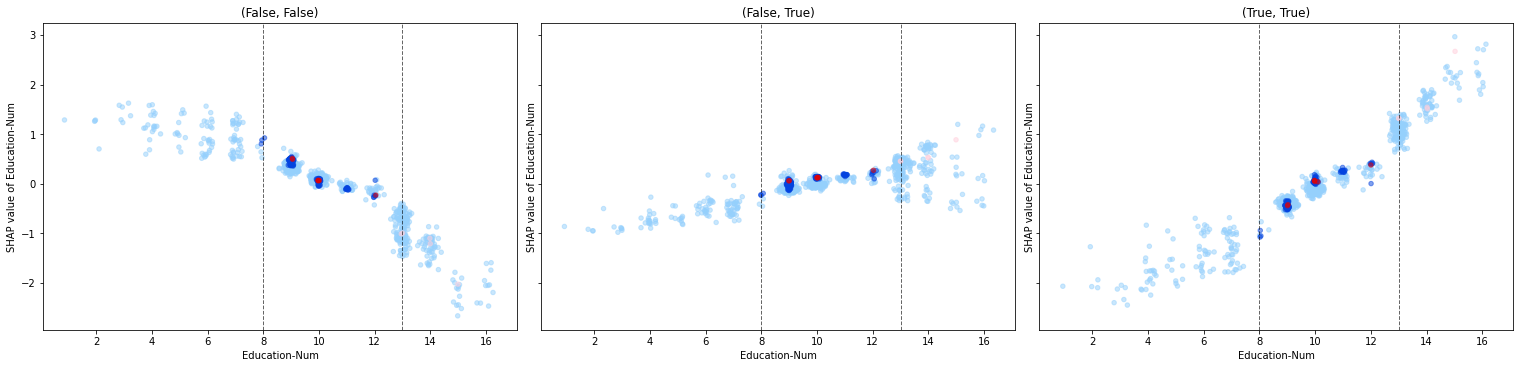

In [69]:
plot(next(feature_it))

4.0 <= Workclass <= 5.0
[Upper CF: Workclass == 6.0 --> {'(False, False)': 7}]


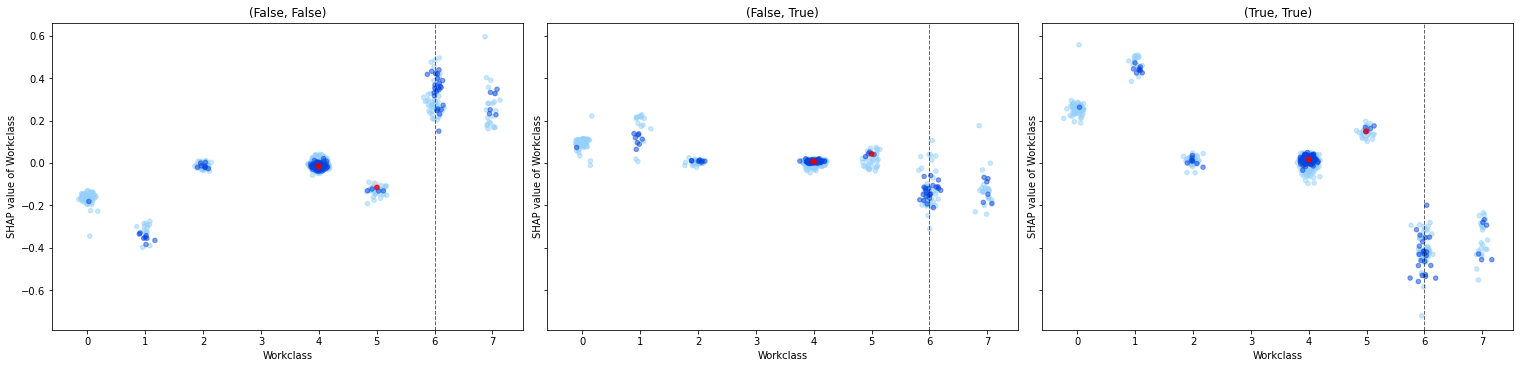

In [70]:
plot(next(feature_it))

Capital Loss <= 1.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 7}]


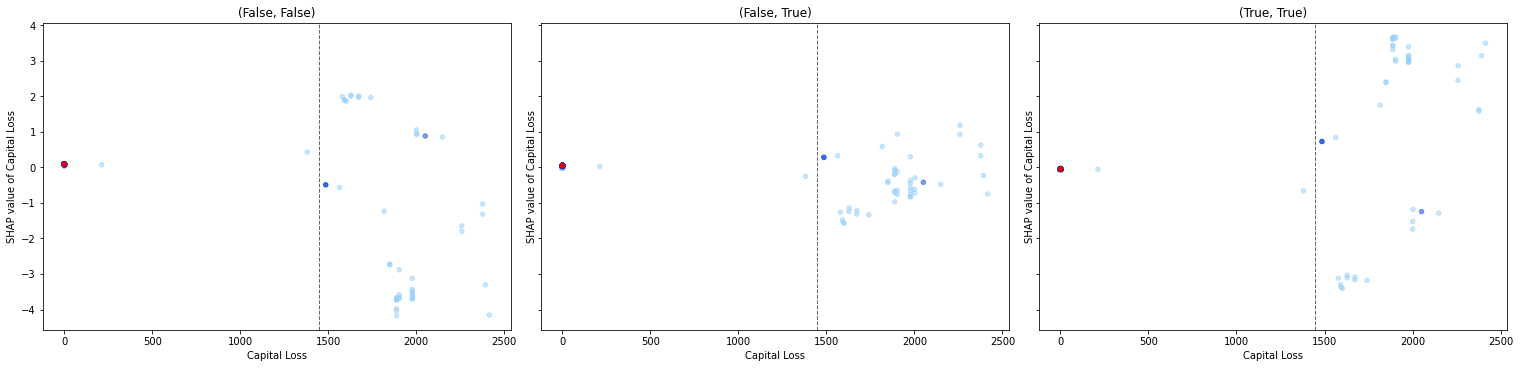

In [71]:
plot(next(feature_it))

Race == 4.0
[Lower CF: Race == 0.0 --> {'(False, False)': 7}]


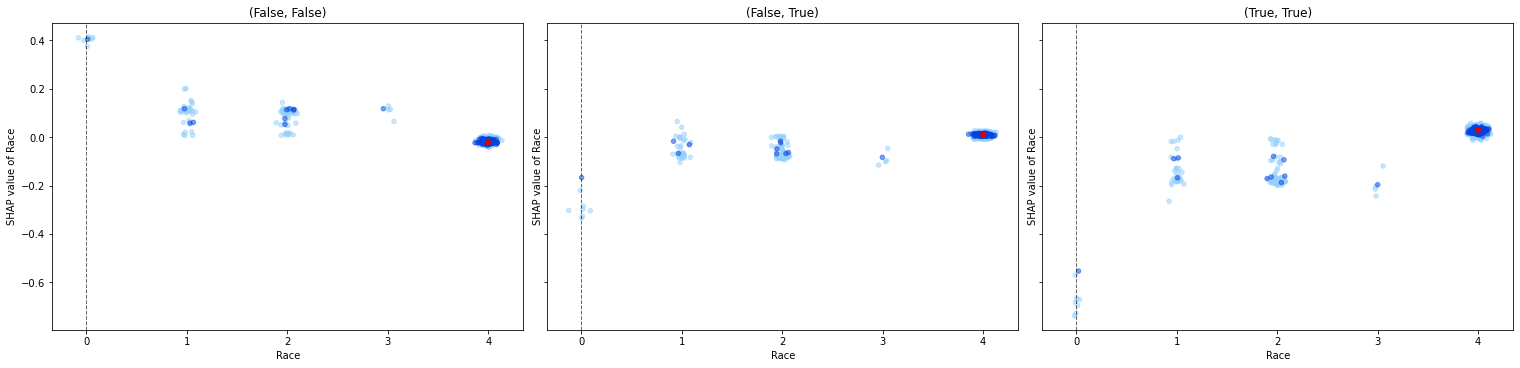

In [72]:
plot(next(feature_it))

Here too, Marital Status CF is missing.

Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.70      0.83       166
        True       0.12      1.00      0.22         7

    accuracy                           0.72       173
   macro avg       0.56      0.85      0.52       173
weighted avg       0.96      0.72      0.80       173



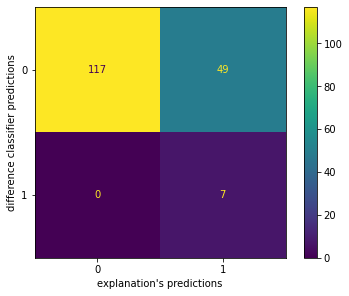

In [73]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('Relationship', 'Age', 'Hours per week', 'Education-Num', 'Capital Gain', 'Workclass')
print(rule)
node.parent.evaluate_rules(rule)

In [74]:
explanations_l2.append((rule, constraint, instance_indices))

### Evaluation

#### Global Fidelity

##### Global

In [75]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

1. 27.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Education-Num` > 8.0 and `Capital Gain` <= 7073.0
              precision    recall  f1-score   support

       False       1.00      0.72      0.84       965
        True       0.04      1.00      0.08        12

    accuracy                           0.73       977
   macro avg       0.52      0.86      0.46       977
weighted avg       0.99      0.73      0.83       977



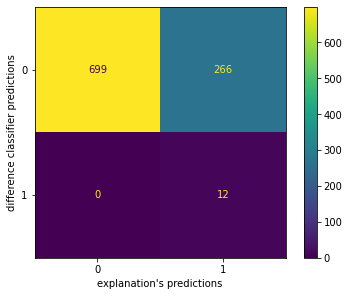

In [76]:
print_rules(rules)
node.root.evaluate_rules(*rules)

##### Level 1

In [77]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

1. Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 27.0 < Age <= 79.0 and 8.0 < `Education-Num` <= 14.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0
              precision    recall  f1-score   support

       False       1.00      0.88      0.94       965
        True       0.09      1.00      0.17        12

    accuracy                           0.88       977
   macro avg       0.55      0.94      0.55       977
weighted avg       0.99      0.88      0.93       977



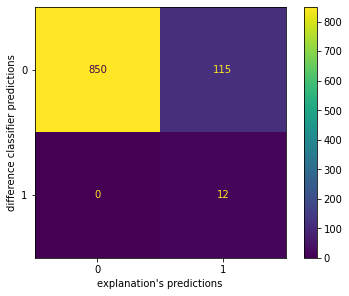

In [78]:
print_rules(rules)
node.root.evaluate_rules(*rules)

##### Level 2

In [79]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

1. Relationship <= 3.0 and `Education-Num` > 13.0 and 29.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and 9.0 < Occupation <= 13.0 and Sex > 0.0 and `Capital Gain` <= 7073.0
2. Relationship > 3.0 and 12.0 < `Education-Num` <= 14.0 and 27.0 < Age <= 39.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and Workclass > 1.0
3. Relationship > 3.0 and 33.0 < Age <= 79.0 and 39.0 < `Hours per week` <= 41.0 and `Capital Gain` <= 56.0 and 8.0 < `Education-Num` <= 12.0 and Workclass <= 5.0
              precision    recall  f1-score   support

       False       1.00      0.94      0.97       965
        True       0.16      1.00      0.28        12

    accuracy                           0.94       977
   macro avg       0.58      0.97      0.62       977
weighted avg       0.99      0.94      0.96       977



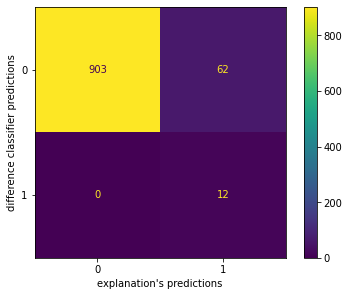

In [80]:
print_rules(rules)
node.root.evaluate_rules(*rules)

#### Counterfactual Fidelity Error

##### Global

In [81]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [82]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [83]:
rmse

Age                 21.245588
Workclass                 NaN
Education-Num        3.201562
Marital Status            NaN
Occupation                NaN
Relationship              NaN
Race                      NaN
Sex                       NaN
Capital Gain      6718.266015
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [84]:
boundary_miss_rate

Age               0.000000
Workclass         1.000000
Education-Num     0.478261
Marital Status    1.000000
Occupation        1.000000
Relationship      1.000000
Race              1.000000
Sex               1.000000
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [85]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        NaN
Relationship      NaN
Race              NaN
Sex               NaN
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

##### Level 1

In [86]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [87]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [88]:
rmse

Age                 21.170931
Workclass                 NaN
Education-Num        2.458751
Marital Status            NaN
Occupation           1.000000
Relationship         1.258306
Race                      NaN
Sex                  0.000000
Capital Gain      2025.633419
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [89]:
boundary_miss_rate

Age               0.000000
Workclass         1.000000
Education-Num     0.043478
Marital Status    1.000000
Occupation        0.826087
Relationship      0.368421
Race              1.000000
Sex               0.777778
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [90]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

##### Level 2

In [91]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [92]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [93]:
rmse

Age                 12.820881
Workclass            0.000000
Education-Num        1.066004
Marital Status            NaN
Occupation           1.000000
Relationship         1.258306
Race                      NaN
Sex                  0.000000
Capital Gain      2025.633419
Capital Loss              NaN
Hours per week       0.000000
Country                   NaN
dtype: float64

In [94]:
boundary_miss_rate

Age               0.000000
Workclass         0.550000
Education-Num     0.043478
Marital Status    1.000000
Occupation        0.826087
Relationship      0.368421
Race              1.000000
Sex               0.777778
Capital Gain      0.076923
Capital Loss      1.000000
Hours per week    0.000000
Country           1.000000
dtype: float64

In [95]:
boundary_add_rate

Age               0.0
Workclass         0.1
Education-Num     0.0
Marital Status    NaN
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

#### Complexity

##### Global

In [96]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [97]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 6 (6.0 per rule)


##### Level 1

In [98]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [99]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 18 (9.0 per rule)


##### Level 2

In [100]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [101]:
print_complexity(constraints)

Number of rules: 3
Number of constraints: 28 (9.3 per rule)


#### Stability

##### Global

In [102]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [103]:
with open('explanation-shap-orig-01-l0.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [109]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [110]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    12
Name: test, dtype: int64


In [121]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [122]:
rmse

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        NaN
Relationship      NaN
Race              NaN
Sex               NaN
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [123]:
boundary_miss_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        NaN
Relationship      NaN
Race              NaN
Sex               NaN
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [124]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        NaN
Relationship      NaN
Race              NaN
Sex               NaN
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [125]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  0.0        NaN            0.0             NaN         NaN   
  upper  0.0        NaN            NaN             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN

##### Level 1

In [126]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [127]:
with open('explanation-shap-orig-01-l1.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [128]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [129]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    2
Name: test, dtype: int64
rule 2:
2    10
Name: test, dtype: int64


In [130]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [131]:
rmse

Age               7.826238
Workclass              NaN
Education-Num     0.000000
Marital Status         NaN
Occupation        0.000000
Relationship      2.121320
Race                   NaN
Sex               0.000000
Capital Gain      0.000000
Capital Loss           NaN
Hours per week    0.000000
Country                NaN
dtype: float64

In [132]:
boundary_miss_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    1.0
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [133]:
boundary_add_rate

Age               0.0
Workclass         NaN
Education-Num     0.0
Marital Status    NaN
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [134]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  -7.0        NaN            0.0             NaN         0.0   
  upper  14.0        NaN            NaN             NaN         0.0   
2 lower   0.0        NaN            0.0             NaN         NaN   
  upper   0.0        NaN            0.0             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  0.0           NaN           NaN             0.0   
  upper           3.0   NaN  NaN           0.0           NaN             0.0   
2 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN  
2 lower      NaN  
  upper      NaN

##### Level 2

In [135]:
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [136]:
with open('explanation-shap-orig-01-l2.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [137]:
indices = node.root.instance_indices[node.root.highlight]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, constraint_matrix_to_rules(constraints_orig, feature_names)).apply(X[indices]),
    RuleClassifier(feature_names, rules).apply(X[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

In [138]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    2
Name: test, dtype: int64
rule 2:
2    3
Name: test, dtype: int64
rule 3:
3    7
Name: test, dtype: int64


In [139]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    calc_constraint_error(feature_names, constraints_orig, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [140]:
rmse

Age               6.595453
Workclass         0.000000
Education-Num     0.000000
Marital Status         NaN
Occupation        0.000000
Relationship      1.732051
Race                   NaN
Sex               0.000000
Capital Gain      0.000000
Capital Loss           NaN
Hours per week    0.000000
Country                NaN
dtype: float64

In [141]:
boundary_miss_rate

Age               0.0
Workclass         0.0
Education-Num     0.0
Marital Status    1.0
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [142]:
boundary_add_rate

Age               0.0
Workclass         0.5
Education-Num     0.0
Marital Status    NaN
Occupation        0.0
Relationship      0.0
Race              NaN
Sex               0.0
Capital Gain      0.0
Capital Loss      NaN
Hours per week    0.0
Country           NaN
dtype: float64

In [143]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  -7.0        NaN            0.0             NaN         0.0   
  upper  14.0        NaN            NaN             NaN         0.0   
2 lower   0.0        NaN            0.0             NaN         NaN   
  upper  -4.0        NaN            0.0             NaN         NaN   
3 lower   0.0        NaN            0.0             NaN         NaN   
  upper   0.0        0.0            0.0             NaN         NaN   

         Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
1 lower           NaN   NaN  0.0           NaN           NaN             0.0   
  upper           3.0   NaN  NaN           0.0           NaN             0.0   
2 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   
3 lower           0.0   NaN  NaN           NaN           NaN             0.0   
  upper           NaN   NaN  NaN           0.0           NaN             0.0   

         Country  
1 lower      NaN  
  upper      NaN  
2 lower      NaN  
  upper      NaN  
3 lower      NaN  
  upper      NaN